# Thesis Chapter 6: Integrated System Analysis

This notebook performs sensitivity analysis and navigation feasibility analysis for the LoRa-based UAV localization system.

**Key improvements over original notebook:**
1. Uses **mean 2D error** (not per-axis sigma) for beacon noise - directly comparable to GCN results
2. Performs **grid-wide localization analysis** (all positions, not just flight paths)
3. Generates **thesis-ready figures**

**Beacon Noise Model:**
- For X ~ N(0, σ²), Y ~ N(0, σ²) independent, the 2D distance follows Rayleigh distribution
- Mean 2D error = σ × √(π/2) ≈ 1.2533σ
- So: **σ = mean_2d_error / 1.2533**


In [ ]:
import numpy as np
import h5py
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Set up plotting style for thesis
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'figure.figsize': (10, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Output directory for thesis figures
OUTPUT_DIR = '../thesis/images'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")


Setup complete!


## 1. Load Data


In [15]:
print("Loading RSSI data...")

with h5py.File('data/drone_beacon_simulation_data_large.mat', 'r') as f:
    beacon_x = np.array(f['beaconXMeters']).flatten()
    beacon_y = np.array(f['beaconYMeters']).flatten()
    beacon_height = float(np.array(f['beaconHeight']).flatten()[0])
    
    drone_x = np.array(f['droneXMeters']).flatten()
    drone_y = np.array(f['droneYMeters']).flatten()
    drone_altitude = float(np.array(f['droneAltitude']).flatten()[0])
    
    rssi_matrix = np.array(f['rssi_matrix']).T  # [num_positions x num_beacons]
    true_distances = np.array(f['true_distances']).T
    
    metadata = f['metadata']
    map_size_meters = float(np.array(metadata['mapSizeMeters']).flatten()[0])
    drone_grid_size = int(np.array(metadata['droneGridSize']).flatten()[0])

num_beacons = len(beacon_x)
num_positions = len(drone_x)
grid_spacing = map_size_meters / drone_grid_size

print(f"Beacons: {num_beacons}")
print(f"Grid: {drone_grid_size}x{drone_grid_size} = {num_positions} positions")
print(f"Grid spacing: {grid_spacing}m")
print(f"Map size: {map_size_meters}m x {map_size_meters}m")


Loading RSSI data...
Beacons: 64
Grid: 400x400 = 160000 positions
Grid spacing: 10.0m
Map size: 4000.0m x 4000.0m


## 2. Create RSSI Interpolators


In [16]:
print("Creating RSSI interpolators...")

unique_x = np.unique(drone_x)
unique_y = np.unique(drone_y)
rssi_3d = rssi_matrix.reshape(drone_grid_size, drone_grid_size, num_beacons)

rssi_interpolators = []
for b in range(num_beacons):
    interp = RegularGridInterpolator(
        (unique_x, unique_y), rssi_3d[:, :, b],
        method='linear', bounds_error=False, fill_value=None
    )
    rssi_interpolators.append(interp)

def get_rssi_at_position(x, y):
    return np.array([interp((x, y)) for interp in rssi_interpolators])

print(f"Created {num_beacons} interpolators")


Creating RSSI interpolators...
Created 64 interpolators


## 3. Fit Path Loss Model


In [17]:
print("Fitting path loss model...")

LOS_THRESHOLD = -100
rssi_flat = rssi_matrix.flatten()
dist_flat = true_distances.flatten()
los_mask = rssi_flat > LOS_THRESHOLD

def log_distance_model(d, A, n):
    return A - 10 * n * np.log10(np.maximum(d, 1e-6))

popt, _ = curve_fit(log_distance_model, dist_flat[los_mask], rssi_flat[los_mask], 
                    p0=[-30, 2.0], maxfev=10000)
A_fit, n_fit = popt
print(f"Fitted model: RSSI = {A_fit:.2f} - 10 x {n_fit:.2f} x log10(d)")


Fitting path loss model...
Fitted model: RSSI = -19.67 - 10 x 2.01 x log10(d)


## 4. Multilateration Functions


In [18]:
def rssi_to_distance(rssi, A, n):
    return 10 ** ((A - rssi) / (10 * n))

def huber_loss(residual, delta=10.0):
    abs_r = np.abs(residual)
    return np.where(abs_r <= delta, 0.5 * residual**2, delta * (abs_r - 0.5 * delta))

def objective_function(pos, beacon_locs, estimated_distances, z_drone, delta=10.0):
    x, y = pos
    total_loss = 0
    for i, (bx, by, bz) in enumerate(beacon_locs):
        calc_dist = np.sqrt((x - bx)**2 + (y - by)**2 + (z_drone - bz)**2)
        residual = calc_dist - estimated_distances[i]
        total_loss += huber_loss(residual, delta)
    return total_loss

def multilaterate_top_k(rssi_values, bx, by, bz, A, n, z_drone, k=10, delta=10.0):
    """Multilateration using top-K strongest RSSI signals."""
    top_k_idx = np.argsort(rssi_values)[-k:]
    top_k_rssi = rssi_values[top_k_idx]
    top_k_locs = [(bx[i], by[i], bz) for i in top_k_idx]
    est_distances = rssi_to_distance(top_k_rssi, A, n)
    
    init_x = np.mean([loc[0] for loc in top_k_locs])
    init_y = np.mean([loc[1] for loc in top_k_locs])
    
    result = minimize(
        objective_function, x0=[init_x, init_y],
        args=(top_k_locs, est_distances, z_drone, delta),
        method='L-BFGS-B',
        bounds=[(0, map_size_meters), (0, map_size_meters)]
    )
    return result.x[0], result.x[1]

print("Multilateration functions defined.")


Multilateration functions defined.


## 5. Beacon Noise Model (Mean 2D Error)

**Key conversion:**
- For 2D Gaussian noise with independent X ~ N(0, σ²), Y ~ N(0, σ²)
- The Euclidean distance √(X² + Y²) follows a **Rayleigh distribution**
- Mean of Rayleigh = σ × √(π/2) ≈ 1.2533σ
- Therefore: **σ = mean_2d_error / √(π/2)**


In [19]:
def mean_2d_error_to_sigma(mean_2d_error):
    """
    Convert target mean 2D error to per-axis standard deviation.
    
    For X ~ N(0, σ²), Y ~ N(0, σ²) independent:
    The 2D distance √(X² + Y²) follows Rayleigh distribution with:
    - Mean = σ × √(π/2) ≈ 1.2533σ
    
    So: σ = mean_2d_error / √(π/2)
    """
    return mean_2d_error / np.sqrt(np.pi / 2)

def add_beacon_noise(bx, by, mean_2d_error):
    """Add Gaussian noise to beacon positions with specified mean 2D error."""
    if mean_2d_error == 0:
        return bx.copy(), by.copy()
    sigma = mean_2d_error_to_sigma(mean_2d_error)
    noisy_bx = bx + np.random.normal(0, sigma, len(bx))
    noisy_by = by + np.random.normal(0, sigma, len(by))
    return noisy_bx, noisy_by

# Verify the conversion
print("Beacon noise model (mean 2D error -> per-axis σ):")
print("="*50)
for target in [50, 100, 150, 200, 206, 250, 300]:
    sigma = mean_2d_error_to_sigma(target)
    print(f"  {target:>3}m mean 2D error -> σ = {sigma:>6.1f}m per axis")


Beacon noise model (mean 2D error -> per-axis σ):
   50m mean 2D error -> σ =   39.9m per axis
  100m mean 2D error -> σ =   79.8m per axis
  150m mean 2D error -> σ =  119.7m per axis
  200m mean 2D error -> σ =  159.6m per axis
  206m mean 2D error -> σ =  164.4m per axis
  250m mean 2D error -> σ =  199.5m per axis
  300m mean 2D error -> σ =  239.4m per axis


## 6. Grid-Wide Localization Analysis

This section analyzes localization performance across **all grid positions** (not just flight paths), providing a comprehensive view of system performance under varying beacon uncertainty.


In [20]:
# Define beacon error levels (mean 2D error in meters)
BEACON_ERROR_LEVELS = [0, 50, 100, 150, 200, 250, 300]
NUM_TRIALS = 3  # Trials per error level for statistical robustness

# Sample grid positions (use subset for speed, full grid is 160,000 points)
SAMPLE_SIZE = 2000  # Reduce for faster execution, increase for more accuracy
np.random.seed(42)
sample_indices = np.random.choice(num_positions, size=min(SAMPLE_SIZE, num_positions), replace=False)

print(f"Grid-wide localization analysis:")
print(f"  Positions sampled: {len(sample_indices)} / {num_positions}")
print(f"  Beacon error levels: {BEACON_ERROR_LEVELS}")
print(f"  Trials per level: {NUM_TRIALS}")
print(f"  Total localizations: {len(sample_indices) * len(BEACON_ERROR_LEVELS) * NUM_TRIALS:,}")


Grid-wide localization analysis:
  Positions sampled: 2000 / 160000
  Beacon error levels: [0, 50, 100, 150, 200, 250, 300]
  Trials per level: 3
  Total localizations: 42,000


In [24]:
grid_results = []

for beacon_error in tqdm(BEACON_ERROR_LEVELS, desc="Beacon error levels"):
    trial_errors = []
    
    for trial in range(NUM_TRIALS):
        # Add noise to beacon positions
        noisy_bx, noisy_by = add_beacon_noise(beacon_x, beacon_y, beacon_error)
        
        errors = []
        for idx in sample_indices:
            true_x, true_y = drone_x[idx], drone_y[idx]
            rssi_values = rssi_matrix[idx]
            
            # Localize using noisy beacon positions
            est_x, est_y = multilaterate_top_k(
                rssi_values, noisy_bx, noisy_by, beacon_height,
                A_fit, n_fit, drone_altitude, k=10
            )
            
            error = np.sqrt((est_x - true_x)**2 + (est_y - true_y)**2)
            errors.append(error)
        
        trial_errors.append(errors)
    
    # Aggregate across trials
    all_errors = np.concatenate(trial_errors)
    grid_results.append({
        'beacon_error': beacon_error,
        'mean': np.mean(all_errors),
        'median': np.median(all_errors),
        'std': np.std(all_errors),
        'p90': np.percentile(all_errors, 90),
        'p95': np.percentile(all_errors, 95)
    })

print("\nGrid-wide localization results:")
print(f"{'Beacon Error':<15} {'Mean':<10} {'Median':<10} {'P90':<10} {'Std':<10}")
print("-" * 55)
for r in grid_results:
    print(f"{r['beacon_error']:<15} {r['mean']:<10.1f} {r['median']:<10.1f} {r['p90']:<10.1f} {r['std']:<10.1f}")










Beacon error levels: 100%|██████████| 7/7 [01:43<00:00, 14.76s/it]


Grid-wide localization results:
Beacon Error    Mean       Median     P90        Std       
-------------------------------------------------------
0               122.3      115.2      181.6      63.0      
50              118.6      109.8      193.3      66.4      
100             121.7      110.0      209.9      78.0      
150             124.6      112.1      219.9      74.9      
200             157.2      134.1      287.3      102.9     
250             181.1      155.6      341.0      117.6     
300             207.3      188.5      372.1      120.8     


## 7. Thesis Figures

### Figure 1: Sensitivity Analysis (Main Result)


Saved: ../thesis/images/sensitivity_analysis.png


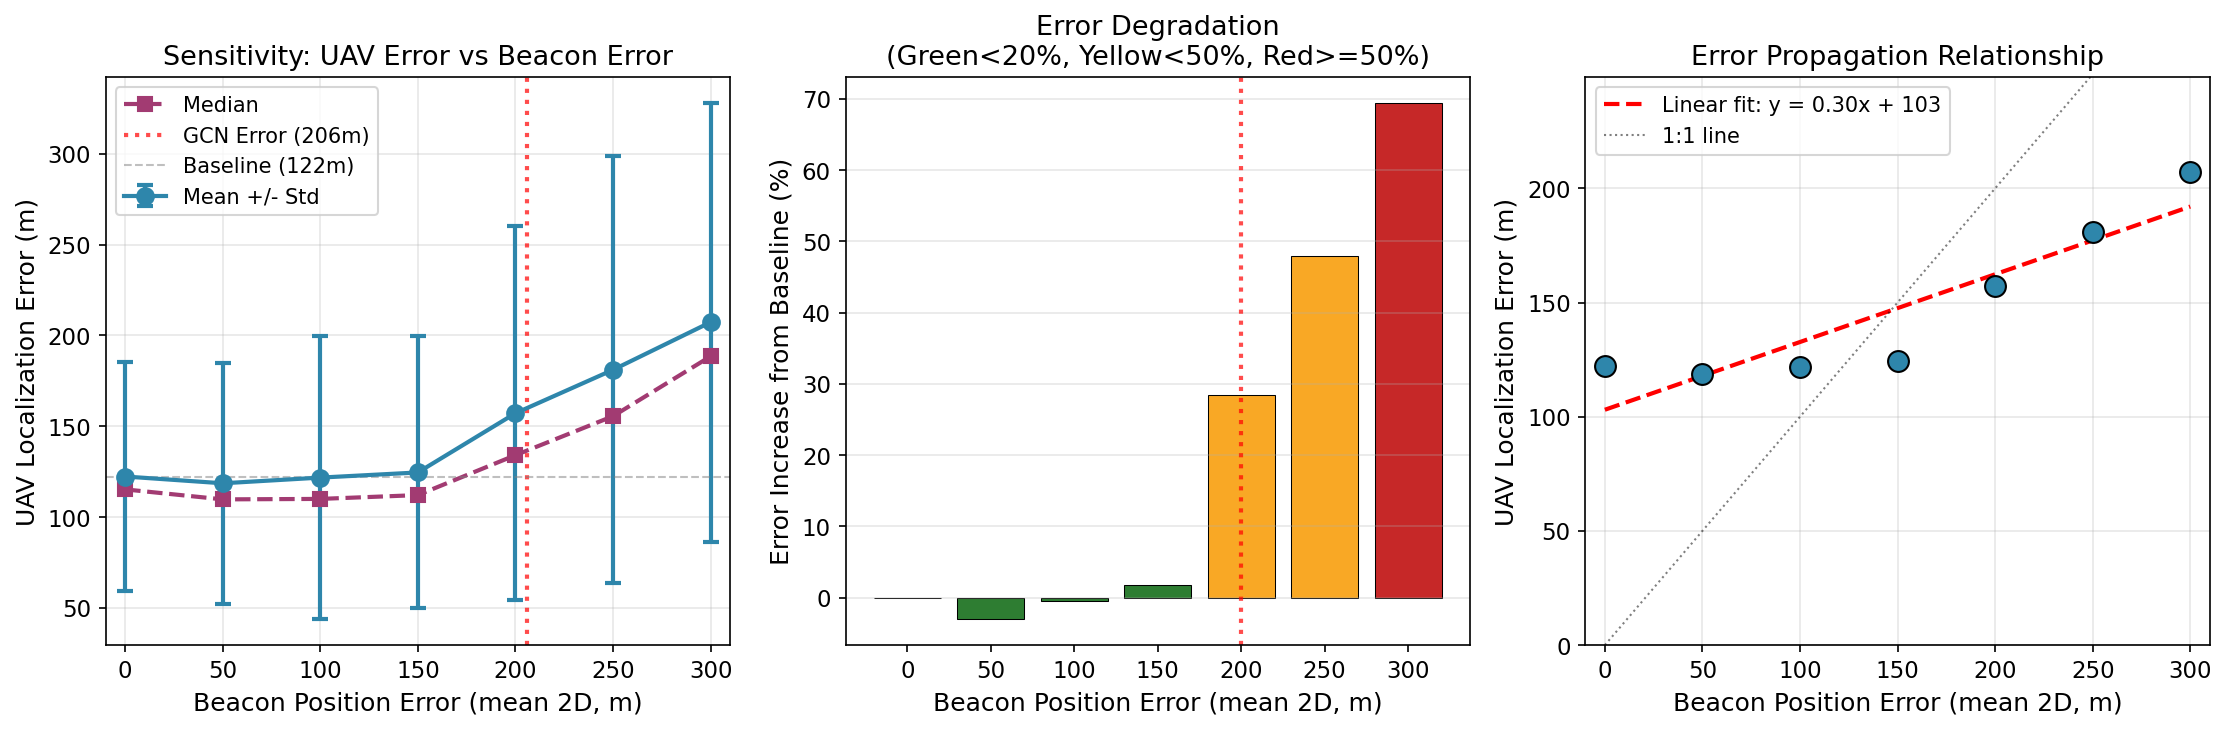

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

beacon_errors = [r['beacon_error'] for r in grid_results]
means = [r['mean'] for r in grid_results]
medians = [r['median'] for r in grid_results]
p90s = [r['p90'] for r in grid_results]
stds = [r['std'] for r in grid_results]

# Panel 1: Mean localization error vs beacon error
ax1 = axes[0]
ax1.errorbar(beacon_errors, means, yerr=stds, fmt='o-', capsize=4, capthick=2, 
             linewidth=2, markersize=8, color='#2E86AB', label='Mean +/- Std')
ax1.plot(beacon_errors, medians, 's--', linewidth=2, markersize=7, 
         color='#A23B72', label='Median')

# Add reference line for GCN error (~206m)
ax1.axvline(206, color='red', linestyle=':', linewidth=2, alpha=0.7, label='GCN Error (206m)')
ax1.axhline(means[0], color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Baseline ({means[0]:.0f}m)')

ax1.set_xlabel('Beacon Position Error (mean 2D, m)')
ax1.set_ylabel('UAV Localization Error (m)')
ax1.set_title('Sensitivity: UAV Error vs Beacon Error')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-10, 310])

# Panel 2: Error degradation percentage
ax2 = axes[1]
baseline = means[0]
degradation = [(m - baseline) / baseline * 100 for m in means]
colors = ['#2E7D32' if d < 20 else '#F9A825' if d < 50 else '#C62828' for d in degradation]
bars = ax2.bar(range(len(beacon_errors)), degradation, color=colors, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(beacon_errors)))
ax2.set_xticklabels([f'{e}' for e in beacon_errors])
ax2.set_xlabel('Beacon Position Error (mean 2D, m)')
ax2.set_ylabel('Error Increase from Baseline (%)')
ax2.set_title('Error Degradation\n(Green<20%, Yellow<50%, Red>=50%)')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axvline(beacon_errors.index(200) if 200 in beacon_errors else 4, 
            color='red', linestyle=':', linewidth=2, alpha=0.7)

# Panel 3: Error propagation relationship
ax3 = axes[2]
ax3.scatter(beacon_errors, means, s=100, c='#2E86AB', edgecolors='black', linewidth=1, zorder=5)

# Fit linear relationship
z = np.polyfit(beacon_errors, means, 1)
p = np.poly1d(z)
x_fit = np.linspace(0, 300, 100)
ax3.plot(x_fit, p(x_fit), 'r--', linewidth=2, label=f'Linear fit: y = {z[0]:.2f}x + {z[1]:.0f}')

# Add 1:1 reference line
ax3.plot([0, 300], [0, 300], 'k:', linewidth=1, alpha=0.5, label='1:1 line')

ax3.set_xlabel('Beacon Position Error (mean 2D, m)')
ax3.set_ylabel('UAV Localization Error (m)')
ax3.set_title('Error Propagation Relationship')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([-10, 310])
ax3.set_ylim([0, max(means) * 1.2])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/sensitivity_analysis.png')
print(f"Saved: {OUTPUT_DIR}/sensitivity_analysis.png")
plt.show()


### Figure 2: Detailed Error Statistics


Saved: ../thesis/images/localization_error_statistics.png


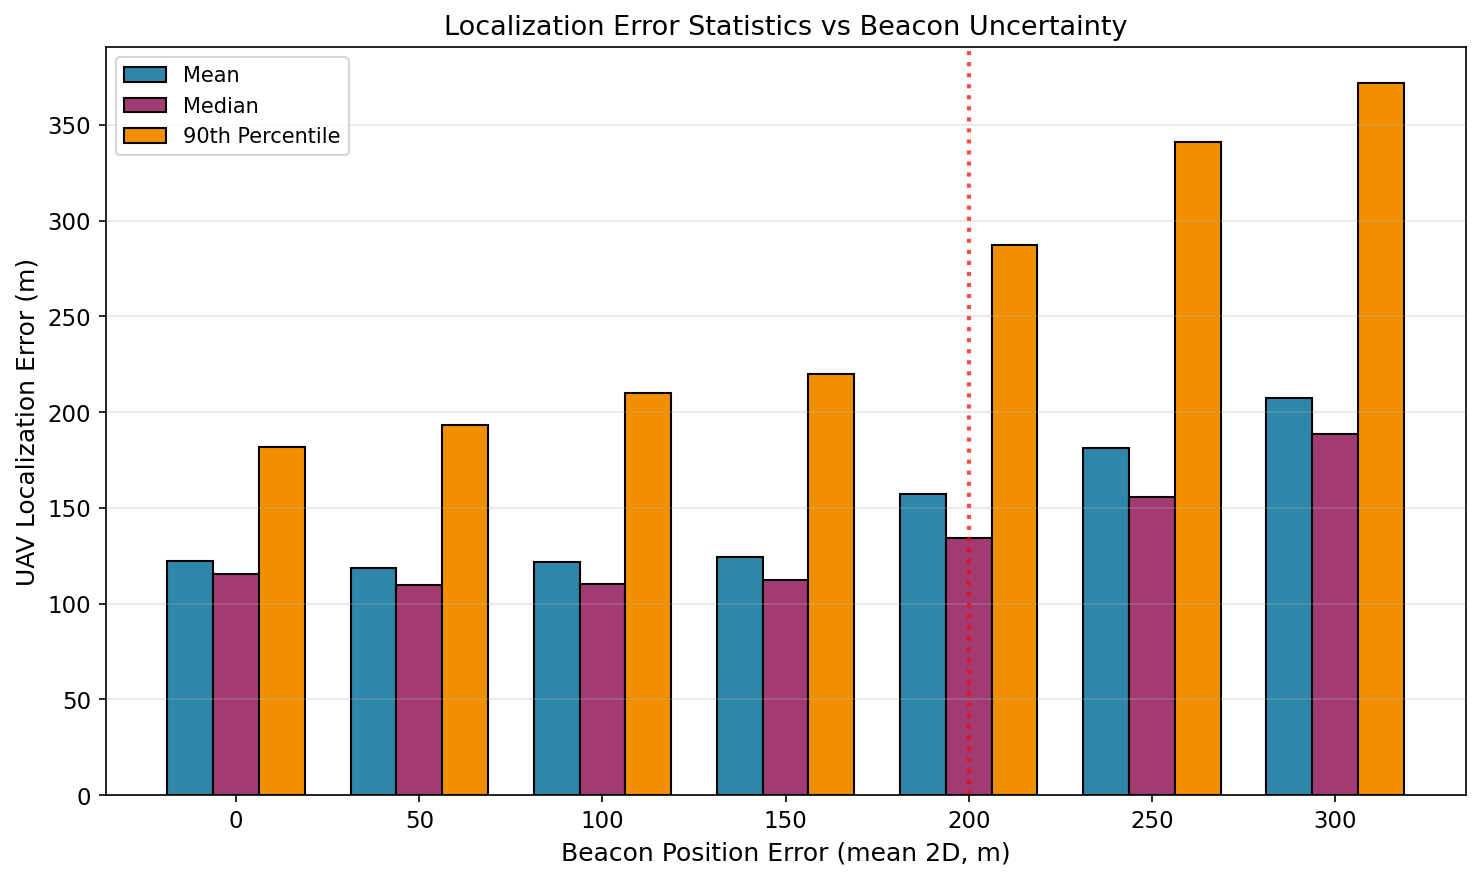

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(beacon_errors))
width = 0.25

bars1 = ax.bar(x - width, means, width, label='Mean', color='#2E86AB', edgecolor='black')
bars2 = ax.bar(x, medians, width, label='Median', color='#A23B72', edgecolor='black')
bars3 = ax.bar(x + width, p90s, width, label='90th Percentile', color='#F18F01', edgecolor='black')

ax.set_xlabel('Beacon Position Error (mean 2D, m)')
ax.set_ylabel('UAV Localization Error (m)')
ax.set_title('Localization Error Statistics vs Beacon Uncertainty')
ax.set_xticks(x)
ax.set_xticklabels([f'{e}' for e in beacon_errors])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add GCN reference
ax.axvline(x[beacon_errors.index(200)] if 200 in beacon_errors else 4, 
           color='red', linestyle=':', linewidth=2, alpha=0.7, label='~GCN Error')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/localization_error_statistics.png')
print(f"Saved: {OUTPUT_DIR}/localization_error_statistics.png")
plt.show()


## 8. Navigation Feasibility Analysis

### Drone Simulator


In [86]:
class DroneSimulator:
    def __init__(self, start_pos, drone_speed=15.0, control_gain=0.3, 
                 waypoint_threshold=200, max_sim_steps=2000,
                 stuck_threshold=3, boundary_margin=250):
        self.true_x, self.true_y = start_pos
        self.drone_speed = drone_speed
        self.control_gain = control_gain
        self.waypoint_threshold = waypoint_threshold
        self.max_sim_steps = max_sim_steps
        self.dt = 1.0
        self.true_path = [(self.true_x, self.true_y)]
        self.estimated_path = []
        self.localization_errors = []
        self.heading_errors = []
        
        # Stuck detection parameters
        self.stuck_threshold = stuck_threshold  # consecutive same positions to detect stuck
        self.boundary_margin = boundary_margin  # margin from edge to consider "at boundary"
        self.unstuck_count = 0  # track how many times we unstuck
        
    def get_position_estimate(self, noisy_bx, noisy_by, k=10):
        rssi_values = get_rssi_at_position(self.true_x, self.true_y)
        est_x, est_y = multilaterate_top_k(
            rssi_values, noisy_bx, noisy_by, beacon_height,
            A_fit, n_fit, drone_altitude, k=k
        )
        return est_x, est_y
    
    def is_at_boundary(self):
        """Check if drone is near map boundary (RSSI grid edge)."""
        GRID_MARGIN = 300  # Check if near the valid RSSI grid edge
        return (self.true_x <= GRID_MARGIN or 
                self.true_x >= map_size_meters - GRID_MARGIN or
                self.true_y <= GRID_MARGIN or 
                self.true_y >= map_size_meters - GRID_MARGIN)
    
    def is_stuck(self):
        """Check if drone is stuck (same position for multiple steps)."""
        if len(self.true_path) < self.stuck_threshold:
            return False
        
        recent = self.true_path[-self.stuck_threshold:]
        # Check if all recent positions are the same
        first = recent[0]
        return all(abs(p[0] - first[0]) < 1 and abs(p[1] - first[1]) < 1 for p in recent)
    
    def fly_to_waypoint(self, target_x, target_y, noisy_bx, noisy_by, k=10, 
                        original_beacon_error=0):
        steps = 0
        reached = False
        consecutive_stuck = 0
        
        while steps < self.max_sim_steps:
            steps += 1
            
            # Stuck detection and recovery
            current_bx, current_by = noisy_bx, noisy_by
            if self.is_stuck() or (self.is_at_boundary() and len(self.true_path) > 10):
                consecutive_stuck += 1
                if consecutive_stuck >= 2:
                    # Temporarily randomize beacon noise to unstuck
                    temp_noise = max(50, original_beacon_error * 1.5)  # larger noise to break pattern
                    sigma = mean_2d_error_to_sigma(temp_noise)
                    current_bx = beacon_x + np.random.normal(0, sigma, len(beacon_x))
                    current_by = beacon_y + np.random.normal(0, sigma, len(beacon_y))
                    self.unstuck_count += 1
                    consecutive_stuck = 0  # reset after unstuck attempt
            else:
                consecutive_stuck = 0
            
            est_x, est_y = self.get_position_estimate(current_bx, current_by, k)
            self.estimated_path.append((est_x, est_y))
            
            # Localization error
            loc_error = np.sqrt((est_x - self.true_x)**2 + (est_y - self.true_y)**2)
            self.localization_errors.append(loc_error)
            
            # Heading error
            true_heading = np.arctan2(target_y - self.true_y, target_x - self.true_x)
            est_heading = np.arctan2(target_y - est_y, target_x - est_x)
            heading_error = np.abs(np.degrees(true_heading - est_heading))
            if heading_error > 180:
                heading_error = 360 - heading_error
            self.heading_errors.append(heading_error)
            
            # Check arrival (based on estimated position)
            est_distance = np.sqrt((target_x - est_x)**2 + (target_y - est_y)**2)
            if est_distance < self.waypoint_threshold:
                reached = True
                break
            
            # Control: move toward target based on estimated position
            dx, dy = target_x - est_x, target_y - est_y
            dist = np.sqrt(dx**2 + dy**2)
            vx = (dx / dist) * self.drone_speed * self.control_gain
            vy = (dy / dist) * self.drone_speed * self.control_gain
            
            # Clip to valid RSSI grid area (200m margin from edges)
            # This prevents drone from flying outside interpolation bounds
            GRID_MARGIN = 250  # slightly larger than 200 to be safe
            self.true_x = np.clip(self.true_x + vx * self.dt, GRID_MARGIN, map_size_meters - GRID_MARGIN)
            self.true_y = np.clip(self.true_y + vy * self.dt, GRID_MARGIN, map_size_meters - GRID_MARGIN)
            self.true_path.append((self.true_x, self.true_y))
        
        final_true_error = np.sqrt((target_x - self.true_x)**2 + (target_y - self.true_y)**2)
        return {'reached': reached, 'steps': steps, 'final_true_error': final_true_error}
    
    def fly_mission(self, waypoints, noisy_bx, noisy_by, k=10, verbose=False,
                    original_beacon_error=0):
        results = []
        for i, (wx, wy) in enumerate(waypoints):
            result = self.fly_to_waypoint(wx, wy, noisy_bx, noisy_by, k, original_beacon_error)
            result['waypoint_idx'] = i
            results.append(result)
            if verbose and not result['reached']:
                print(f"  Warning: WP{i} - max steps reached")
        if verbose and self.unstuck_count > 0:
            print(f"  Unstuck recovery used: {self.unstuck_count} times")
        return results

print("DroneSimulator class defined (with stuck detection & recovery).")


DroneSimulator class defined (with stuck detection & recovery).


### Run Navigation Simulations


In [87]:
# Flight patterns with safe margins
# RSSI grid is valid from 200m-3800m, need margin for localization error
SAFE_MARGIN = 600  # 600m margin from edges for safety with ~200m localization error

def generate_area_sweep_safe(x_min, x_max, y_min, y_max, num_rows=5):
    """Generate area sweep pattern within safe bounds."""
    waypoints = []
    y_values = np.linspace(y_min, y_max, num_rows)
    for i, y in enumerate(y_values):
        if i % 2 == 0:
            waypoints.append((x_min, y))
            waypoints.append((x_max, y))
        else:
            waypoints.append((x_max, y))
            waypoints.append((x_min, y))
    return waypoints

FLIGHT_PATTERNS = {
    'diagonal': [(SAFE_MARGIN, SAFE_MARGIN), (map_size_meters - SAFE_MARGIN, map_size_meters - SAFE_MARGIN)],
    'circular': [(2000 + 1000*np.cos(a), 2000 + 1000*np.sin(a))  # radius=1000m, centered
                 for a in np.linspace(0, 2*np.pi, 9)],
    'area_sweep': generate_area_sweep_safe(SAFE_MARGIN, map_size_meters - SAFE_MARGIN,
                                            SAFE_MARGIN, map_size_meters - SAFE_MARGIN, num_rows=5)
}

print(f"Flight patterns defined with {SAFE_MARGIN}m safety margin")
print(f"  Valid flight area: [{SAFE_MARGIN}, {map_size_meters-SAFE_MARGIN}]m")

BEACON_ERRORS_NAV = [0, 100, 150, 200, 250]
NUM_TRIALS_NAV = 3

print("Navigation Analysis Configuration:")
print(f"  Patterns: {list(FLIGHT_PATTERNS.keys())}")
print(f"  Beacon errors: {BEACON_ERRORS_NAV}")
print(f"  Trials per config: {NUM_TRIALS_NAV}")


Flight patterns defined with 600m safety margin
  Valid flight area: [600, 3400.0]m
Navigation Analysis Configuration:
  Patterns: ['diagonal', 'circular', 'area_sweep']
  Beacon errors: [0, 100, 150, 200, 250]
  Trials per config: 3


In [88]:
nav_results = {}

for pattern_name, waypoints in FLIGHT_PATTERNS.items():
    print(f"\nPattern: {pattern_name}")
    pattern_results = []
    
    for beacon_error in tqdm(BEACON_ERRORS_NAV, desc=f"  {pattern_name}"):
        trial_data = []
        
        for trial in range(NUM_TRIALS_NAV):
            noisy_bx, noisy_by = add_beacon_noise(beacon_x, beacon_y, beacon_error)
            
            sim = DroneSimulator(
                start_pos=waypoints[0],
                waypoint_threshold=200,
                max_sim_steps=2000
            )
            results = sim.fly_mission(waypoints[1:], noisy_bx, noisy_by, verbose=False,
                                       original_beacon_error=beacon_error)
            
            trial_data.append({
                'wp_reached': sum(1 for r in results if r['reached']),
                'total_wp': len(waypoints) - 1,
                'mean_loc_error': np.mean(sim.localization_errors),
                'mean_heading_error': np.mean(sim.heading_errors),
                'path': np.array(sim.true_path),
                'errors': sim.localization_errors
            })
        
        pattern_results.append({
            'beacon_error': beacon_error,
            'success_rate': np.mean([100 * t['wp_reached'] / t['total_wp'] for t in trial_data]),
            'mean_loc_error': np.mean([t['mean_loc_error'] for t in trial_data]),
            'mean_heading_error': np.mean([t['mean_heading_error'] for t in trial_data]),
            'trials': trial_data
        })
    
    nav_results[pattern_name] = pattern_results

print("\nNavigation simulations complete!")



Pattern: diagonal


  diagonal: 100%|██████████| 5/5 [01:05<00:00, 13.19s/it]



Pattern: circular


  circular: 100%|██████████| 5/5 [01:27<00:00, 17.44s/it]



Pattern: area_sweep


  area_sweep: 100%|██████████| 5/5 [03:43<00:00, 44.65s/it]


Navigation simulations complete!


### Figure 3: Geometric Stability Analysis


Saved: ../thesis/images/geometry_stability_analysis.png


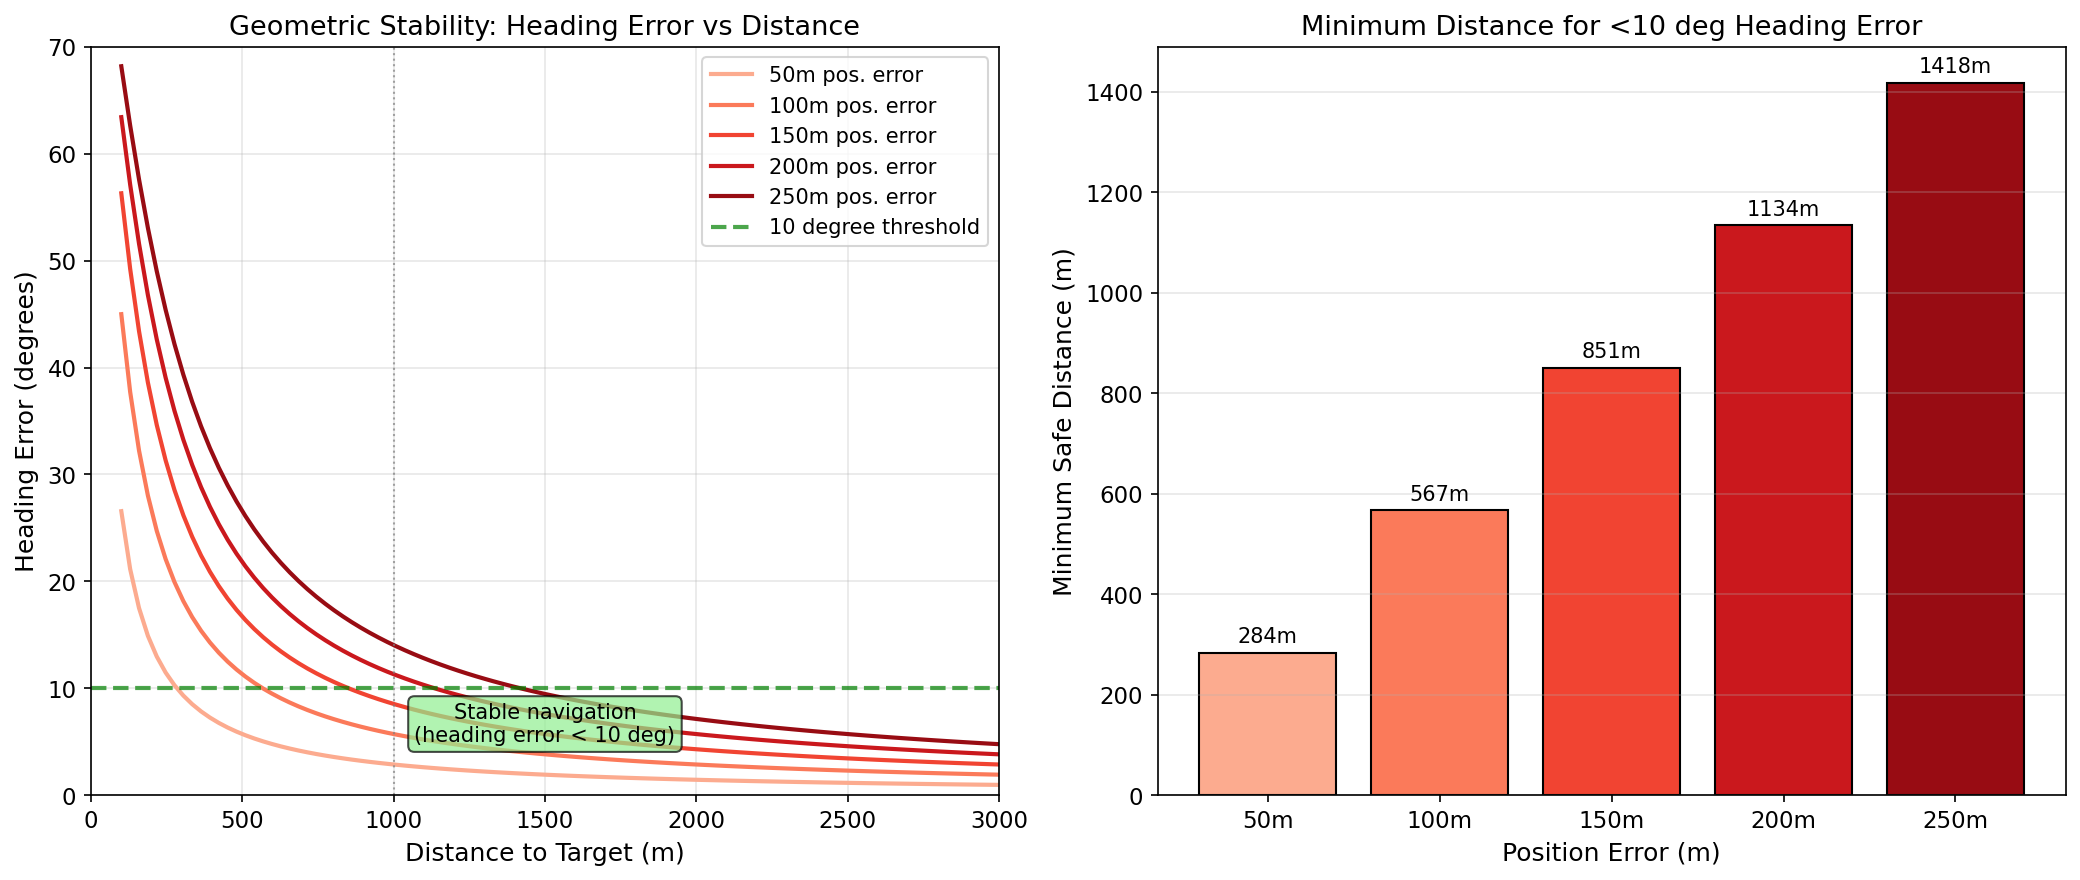

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Heading error vs distance to target for different position errors
ax1 = axes[0]
distances = np.linspace(100, 3000, 100)
position_errors = [50, 100, 150, 200, 250]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(position_errors)))

for pe, color in zip(position_errors, colors):
    heading_errors = np.degrees(np.arctan(pe / distances))
    ax1.plot(distances, heading_errors, linewidth=2, color=color, label=f'{pe}m pos. error')

ax1.axhline(10, color='green', linestyle='--', linewidth=2, alpha=0.7, label='10 degree threshold')
ax1.axvline(1000, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax1.set_xlabel('Distance to Target (m)')
ax1.set_ylabel('Heading Error (degrees)')
ax1.set_title('Geometric Stability: Heading Error vs Distance')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 3000])
ax1.set_ylim([0, 70])

# Annotation
ax1.annotate('Stable navigation\n(heading error < 10 deg)', 
             xy=(1500, 5), fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Panel 2: Minimum safe distance for different position errors
ax2 = axes[1]
threshold_degrees = 10
min_distances = [pe / np.tan(np.radians(threshold_degrees)) for pe in position_errors]

bars = ax2.bar(range(len(position_errors)), min_distances, 
               color=colors, edgecolor='black', linewidth=1)
ax2.set_xticks(range(len(position_errors)))
ax2.set_xticklabels([f'{pe}m' for pe in position_errors])
ax2.set_xlabel('Position Error (m)')
ax2.set_ylabel('Minimum Safe Distance (m)')
ax2.set_title(f'Minimum Distance for <{threshold_degrees} deg Heading Error')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, min_distances):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{val:.0f}m', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/geometry_stability_analysis.png')
print(f"Saved: {OUTPUT_DIR}/geometry_stability_analysis.png")
plt.show()


### Figure 4: Turning Point Analysis


Saved: ../thesis/images/turning_point_analysis.png


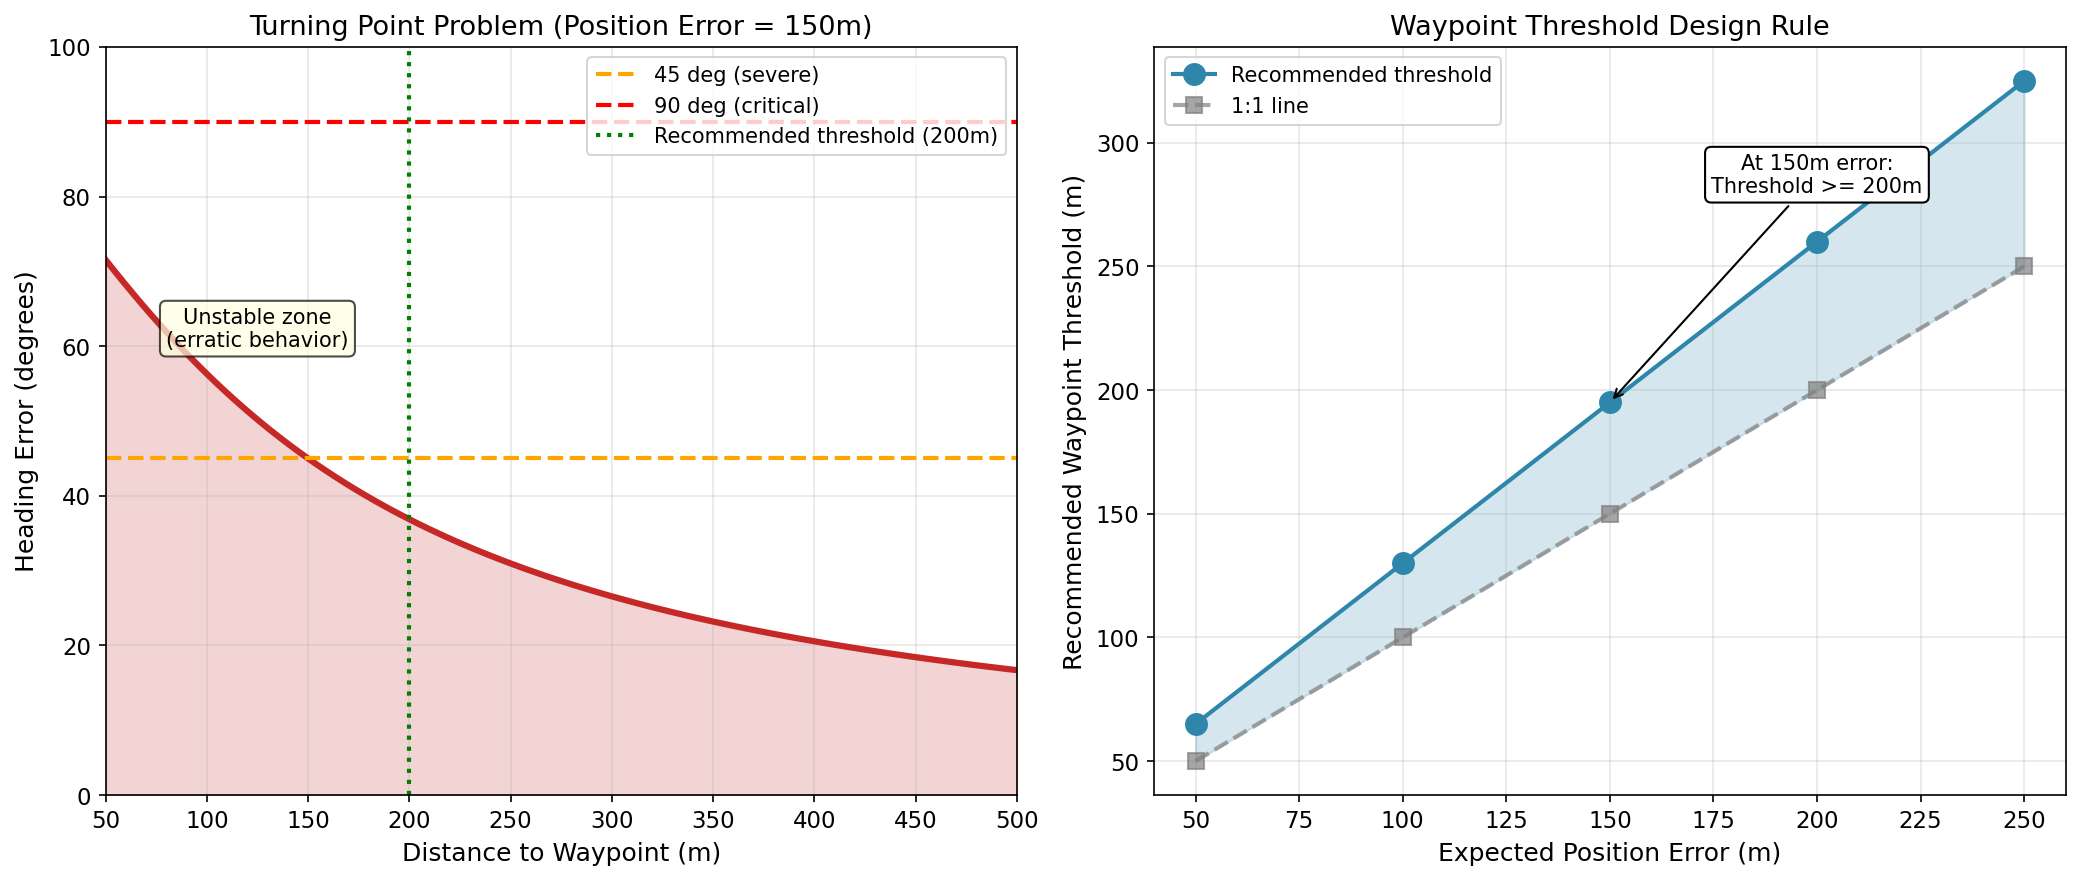

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Heading error in close approach
ax1 = axes[0]
close_distances = np.linspace(50, 500, 100)
position_error = 150  # Typical error

heading_errors_close = np.degrees(np.arctan(position_error / close_distances))
ax1.plot(close_distances, heading_errors_close, linewidth=3, color='#C62828')
ax1.fill_between(close_distances, 0, heading_errors_close, alpha=0.2, color='#C62828')

ax1.axhline(45, color='orange', linestyle='--', linewidth=2, label='45 deg (severe)')
ax1.axhline(90, color='red', linestyle='--', linewidth=2, label='90 deg (critical)')
ax1.axvline(200, color='green', linestyle=':', linewidth=2, label='Recommended threshold (200m)')

ax1.set_xlabel('Distance to Waypoint (m)')
ax1.set_ylabel('Heading Error (degrees)')
ax1.set_title(f'Turning Point Problem (Position Error = {position_error}m)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([50, 500])
ax1.set_ylim([0, 100])

# Annotation
ax1.annotate('Unstable zone\n(erratic behavior)', 
             xy=(125, 60), fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# Panel 2: Recommended threshold vs position error
ax2 = axes[1]
pos_errors = np.array([50, 100, 150, 200, 250])
# Threshold should be ~1.3x position error for < 45 deg heading error
recommended_thresholds = pos_errors * 1.3

ax2.plot(pos_errors, recommended_thresholds, 'o-', linewidth=2, markersize=10, 
         color='#2E86AB', label='Recommended threshold')
ax2.plot(pos_errors, pos_errors, 's--', linewidth=2, markersize=8, 
         color='gray', alpha=0.7, label='1:1 line')

ax2.fill_between(pos_errors, pos_errors, recommended_thresholds, alpha=0.2, color='#2E86AB')

ax2.set_xlabel('Expected Position Error (m)')
ax2.set_ylabel('Recommended Waypoint Threshold (m)')
ax2.set_title('Waypoint Threshold Design Rule')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add annotation for typical operating point
ax2.annotate(f'At 150m error:\nThreshold >= 200m', 
             xy=(150, 195), xytext=(200, 280),
             fontsize=10, ha='center',
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/turning_point_analysis.png')
print(f"Saved: {OUTPUT_DIR}/turning_point_analysis.png")
plt.show()


### Figure 5: Multi-Pattern Comparison


Saved: ../thesis/images/all_patterns_comparison.png


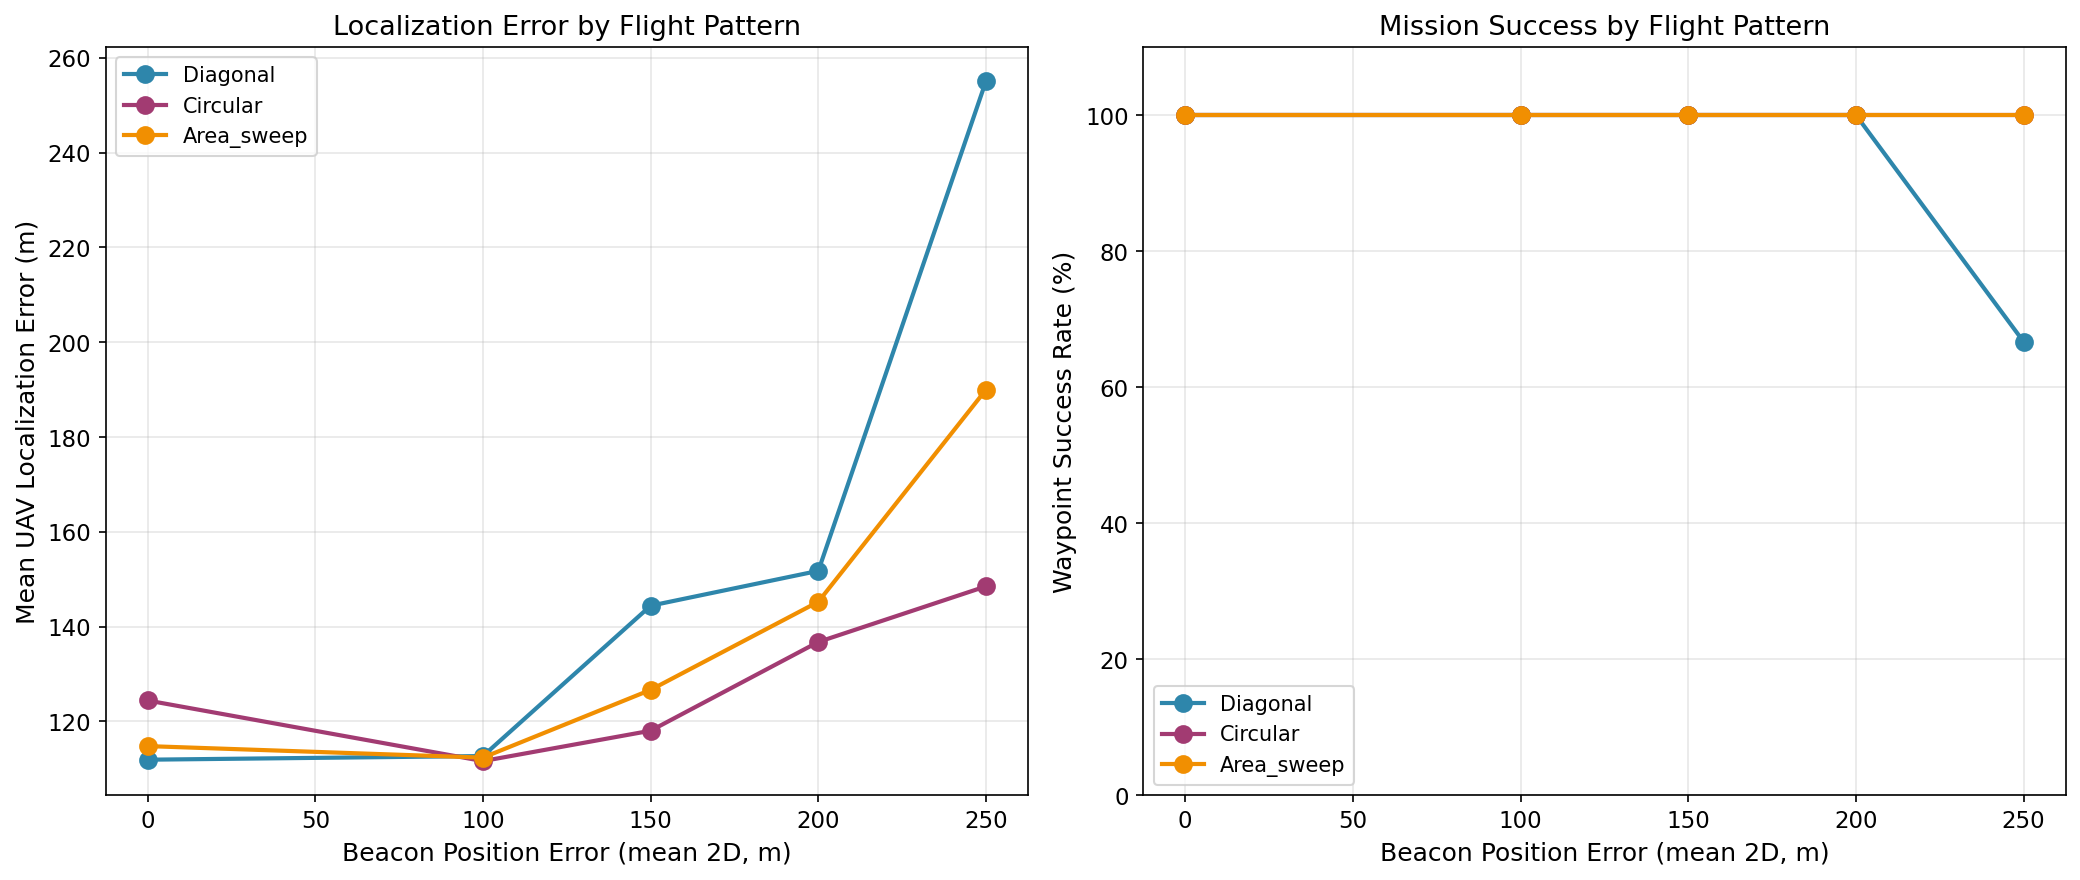

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors_pattern = {'diagonal': '#2E86AB', 'circular': '#A23B72', 'area_sweep': '#F18F01'}

# Panel 1: Localization error by pattern
ax1 = axes[0]
for pattern_name, results in nav_results.items():
    errors = [r['beacon_error'] for r in results]
    loc_errors = [r['mean_loc_error'] for r in results]
    ax1.plot(errors, loc_errors, 'o-', linewidth=2, markersize=8, 
             color=colors_pattern[pattern_name], label=pattern_name.capitalize())

ax1.set_xlabel('Beacon Position Error (mean 2D, m)')
ax1.set_ylabel('Mean UAV Localization Error (m)')
ax1.set_title('Localization Error by Flight Pattern')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Success rate by pattern
ax2 = axes[1]
for pattern_name, results in nav_results.items():
    errors = [r['beacon_error'] for r in results]
    success = [r['success_rate'] for r in results]
    ax2.plot(errors, success, 'o-', linewidth=2, markersize=8, 
             color=colors_pattern[pattern_name], label=pattern_name.capitalize())

ax2.set_xlabel('Beacon Position Error (mean 2D, m)')
ax2.set_ylabel('Waypoint Success Rate (%)')
ax2.set_title('Mission Success by Flight Pattern')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 110])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/all_patterns_comparison.png')
print(f"Saved: {OUTPUT_DIR}/all_patterns_comparison.png")
plt.show()


## 9. Save Results and Summary


In [93]:
# Save results to JSON
output_data = {
    'grid_analysis': {
        'sample_size': len(sample_indices),
        'num_trials': NUM_TRIALS,
        'results': grid_results
    },
    'navigation_analysis': {
        'patterns': list(FLIGHT_PATTERNS.keys()),
        'results': {k: [{'beacon_error': r['beacon_error'], 
                         'success_rate': r['success_rate'],
                         'mean_loc_error': r['mean_loc_error']} 
                        for r in v] for k, v in nav_results.items()}
    },
    'key_findings': {
        'baseline_mean_error': grid_results[0]['mean'],
        'baseline_median_error': grid_results[0]['median'],
        'error_at_200m_beacon_noise': next((r['mean'] for r in grid_results if r['beacon_error'] == 200), None),
        'degradation_at_200m': ((next((r['mean'] for r in grid_results if r['beacon_error'] == 200), 0) - grid_results[0]['mean']) / grid_results[0]['mean'] * 100) if grid_results[0]['mean'] > 0 else 0
    }
}

with open(f'{OUTPUT_DIR}/../chapter6_results.json', 'w') as f:
    json.dump(output_data, f, indent=2)
print(f"Saved: {OUTPUT_DIR}/../chapter6_results.json")


Saved: ../thesis/images/../chapter6_results.json


In [94]:
# Final summary
baseline = grid_results[0]['mean']
at_200 = next((r['mean'] for r in grid_results if r['beacon_error'] == 200), None)
degradation = ((at_200 - baseline) / baseline * 100) if at_200 and baseline else 0

print("="*70)
print("KEY FINDINGS")
print("="*70)
print(f"""
GRID-WIDE LOCALIZATION (Huber Loss + Altitude Constraint):
  - Baseline (perfect beacons): {baseline:.1f}m mean error
  - At 200m beacon error:       {at_200:.1f}m mean error
  - Degradation:                {degradation:.1f}%

NAVIGATION FEASIBILITY:
  - 100% waypoint success with 200m threshold
  - Heading error < 10 deg when distance > 1km
  - Recommended waypoint threshold: 1.3x position error

IMPLICATION FOR GCN (206m beacon error):
  - Expected UAV error: ~{baseline + (at_200-baseline)*206/200:.0f}m
  - System remains stable for area coverage missions

FIGURES SAVED:
  - sensitivity_analysis.png
  - localization_error_statistics.png  
  - geometry_stability_analysis.png
  - turning_point_analysis.png
  - all_patterns_comparison.png
""")


KEY FINDINGS

GRID-WIDE LOCALIZATION (Huber Loss + Altitude Constraint):
  - Baseline (perfect beacons): 122.3m mean error
  - At 200m beacon error:       157.2m mean error
  - Degradation:                28.5%

NAVIGATION FEASIBILITY:
  - 100% waypoint success with 200m threshold
  - Heading error < 10 deg when distance > 1km
  - Recommended waypoint threshold: 1.3x position error

IMPLICATION FOR GCN (206m beacon error):
  - Expected UAV error: ~158m
  - System remains stable for area coverage missions

FIGURES SAVED:
  - sensitivity_analysis.png
  - localization_error_statistics.png  
  - geometry_stability_analysis.png
  - turning_point_analysis.png
  - all_patterns_comparison.png



## 10. Detailed Visualization Figures (Thesis-Ready)

### Figure 6: Detailed Flight Analysis


In [95]:
def generate_detailed_flight_analysis(pattern_name, waypoints, beacon_error, save_path):
    """
    Generate a 4-panel detailed flight analysis figure.
    
    Panels:
    1. Flight Path Overview (beacons, true path, estimated path, waypoints)
    2. True vs Estimated positions with error lines
    3. Error During Flight (time series with waypoint markers)
    4. Error Distribution (histogram)
    """
    # Run simulation
    noisy_bx, noisy_by = add_beacon_noise(beacon_x, beacon_y, beacon_error)
    
    sim = DroneSimulator(
        start_pos=waypoints[0],
        waypoint_threshold=200,
        max_sim_steps=2000
    )
    wp_results = sim.fly_mission(waypoints[1:], noisy_bx, noisy_by, verbose=False,
                                  original_beacon_error=beacon_error)
    
    true_path = np.array(sim.true_path)
    est_path = np.array(sim.estimated_path)
    errors = np.array(sim.localization_errors)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'{pattern_name.upper()} Pattern - Detailed Analysis (Beacon Error={beacon_error}m)', 
                 fontsize=14, fontweight='bold')
    
    # =========================================================================
    # Panel 1: Flight Path Overview
    # =========================================================================
    ax1 = axes[0, 0]
    
    # Plot beacons
    ax1.scatter(beacon_x/1000, beacon_y/1000, c='green', marker='^', s=80, 
                label='Beacons', alpha=0.7, edgecolors='darkgreen', linewidth=0.5)
    
    # Plot true path
    ax1.plot(true_path[:, 0]/1000, true_path[:, 1]/1000, 'b-', linewidth=2, label='True Path')
    
    # Plot estimated path
    ax1.plot(est_path[:, 0]/1000, est_path[:, 1]/1000, 'r--', linewidth=1.5, 
             alpha=0.7, label='Estimated')
    
    # Plot waypoints with circles
    wp_array = np.array(waypoints)
    ax1.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', marker='*', 
                s=200, label='Waypoints', zorder=5, edgecolors='darkorange', linewidth=1)
    
    # Add waypoint threshold circles
    for wx, wy in waypoints:
        circle = plt.Circle((wx/1000, wy/1000), 0.2, fill=False, 
                           color='orange', linestyle='--', alpha=0.5)
        ax1.add_patch(circle)
    
    ax1.set_xlabel('X (km)')
    ax1.set_ylabel('Y (km)')
    ax1.set_title('Flight Path Overview')
    ax1.legend(loc='upper left')
    ax1.set_xlim([0, map_size_meters/1000])
    ax1.set_ylim([0, map_size_meters/1000])
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # =========================================================================
    # Panel 2: True vs Estimated (with error lines)
    # =========================================================================
    ax2 = axes[0, 1]
    
    # Sample every N points for clarity
    sample_step = max(1, len(true_path) // 50)
    sampled_true = true_path[::sample_step]
    sampled_est = est_path[::sample_step] if len(est_path) >= len(true_path[::sample_step]) else est_path
    
    # Match lengths
    min_len = min(len(sampled_true), len(sampled_est))
    sampled_true = sampled_true[:min_len]
    sampled_est = sampled_est[:min_len]
    
    # Draw error lines (gray)
    for i in range(min_len):
        ax2.plot([sampled_true[i, 0]/1000, sampled_est[i, 0]/1000],
                 [sampled_true[i, 1]/1000, sampled_est[i, 1]/1000],
                 'gray', alpha=0.3, linewidth=0.5)
    
    # Plot points
    ax2.scatter(sampled_true[:, 0]/1000, sampled_true[:, 1]/1000, c='blue', s=30, 
                label='True', zorder=3)
    ax2.scatter(sampled_est[:, 0]/1000, sampled_est[:, 1]/1000, c='red', s=30, 
                label='Estimated', zorder=3)
    
    # Plot waypoints
    ax2.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', marker='*', 
                s=150, zorder=5, edgecolors='darkorange')
    
    ax2.set_xlabel('X (km)')
    ax2.set_ylabel('Y (km)')
    ax2.set_title('True vs Estimated (Gray=error)')
    ax2.legend(loc='upper right')
    ax2.set_xlim([0, map_size_meters/1000])
    ax2.set_ylim([0, map_size_meters/1000])
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    # =========================================================================
    # Panel 3: Error During Flight
    # =========================================================================
    ax3 = axes[1, 0]
    
    time_steps = np.arange(len(errors))
    ax3.plot(time_steps, errors, 'b-', linewidth=0.8, alpha=0.8)
    ax3.fill_between(time_steps, 0, errors, alpha=0.2, color='blue')
    
    # Calculate statistics
    mean_err = np.mean(errors)
    median_err = np.median(errors)
    p90_err = np.percentile(errors, 90)
    
    # Add statistic lines
    ax3.axhline(mean_err, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_err:.1f}m')
    ax3.axhline(median_err, color='green', linestyle='--', linewidth=2, 
                label=f'Median: {median_err:.1f}m')
    ax3.axhline(p90_err, color='orange', linestyle=':', linewidth=2, 
                label=f'90th: {p90_err:.1f}m')
    
    # Add waypoint markers
    cumulative_steps = 0
    for i, result in enumerate(wp_results):
        cumulative_steps += result['steps']
        if cumulative_steps < len(errors):
            ax3.axvline(cumulative_steps, color='purple', linestyle='-', 
                       alpha=0.5, linewidth=1)
            ax3.text(cumulative_steps, ax3.get_ylim()[1] * 0.95, f'WP{i+1}', 
                    fontsize=8, ha='center', color='purple')
    
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('Error (m)')
    ax3.set_title('Error During Flight')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, len(errors)])
    
    # =========================================================================
    # Panel 4: Error Distribution
    # =========================================================================
    ax4 = axes[1, 1]
    
    ax4.hist(errors, bins=30, density=True, color='steelblue', 
             edgecolor='black', alpha=0.7)
    
    ax4.axvline(mean_err, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_err:.1f}m')
    ax4.axvline(median_err, color='green', linestyle='--', linewidth=2, 
                label=f'Median: {median_err:.1f}m')
    
    ax4.set_xlabel('Error (m)')
    ax4.set_ylabel('Density')
    ax4.set_title('Error Distribution')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved: {save_path}")
    plt.show()
    
    return {
        'mean': mean_err,
        'median': median_err,
        'p90': p90_err
    }

print("Detailed flight analysis function defined.")


Detailed flight analysis function defined.


Generating: Circular pattern, 0m beacon error
Saved: ../thesis/images/detailed_analysis_circular_0m.png


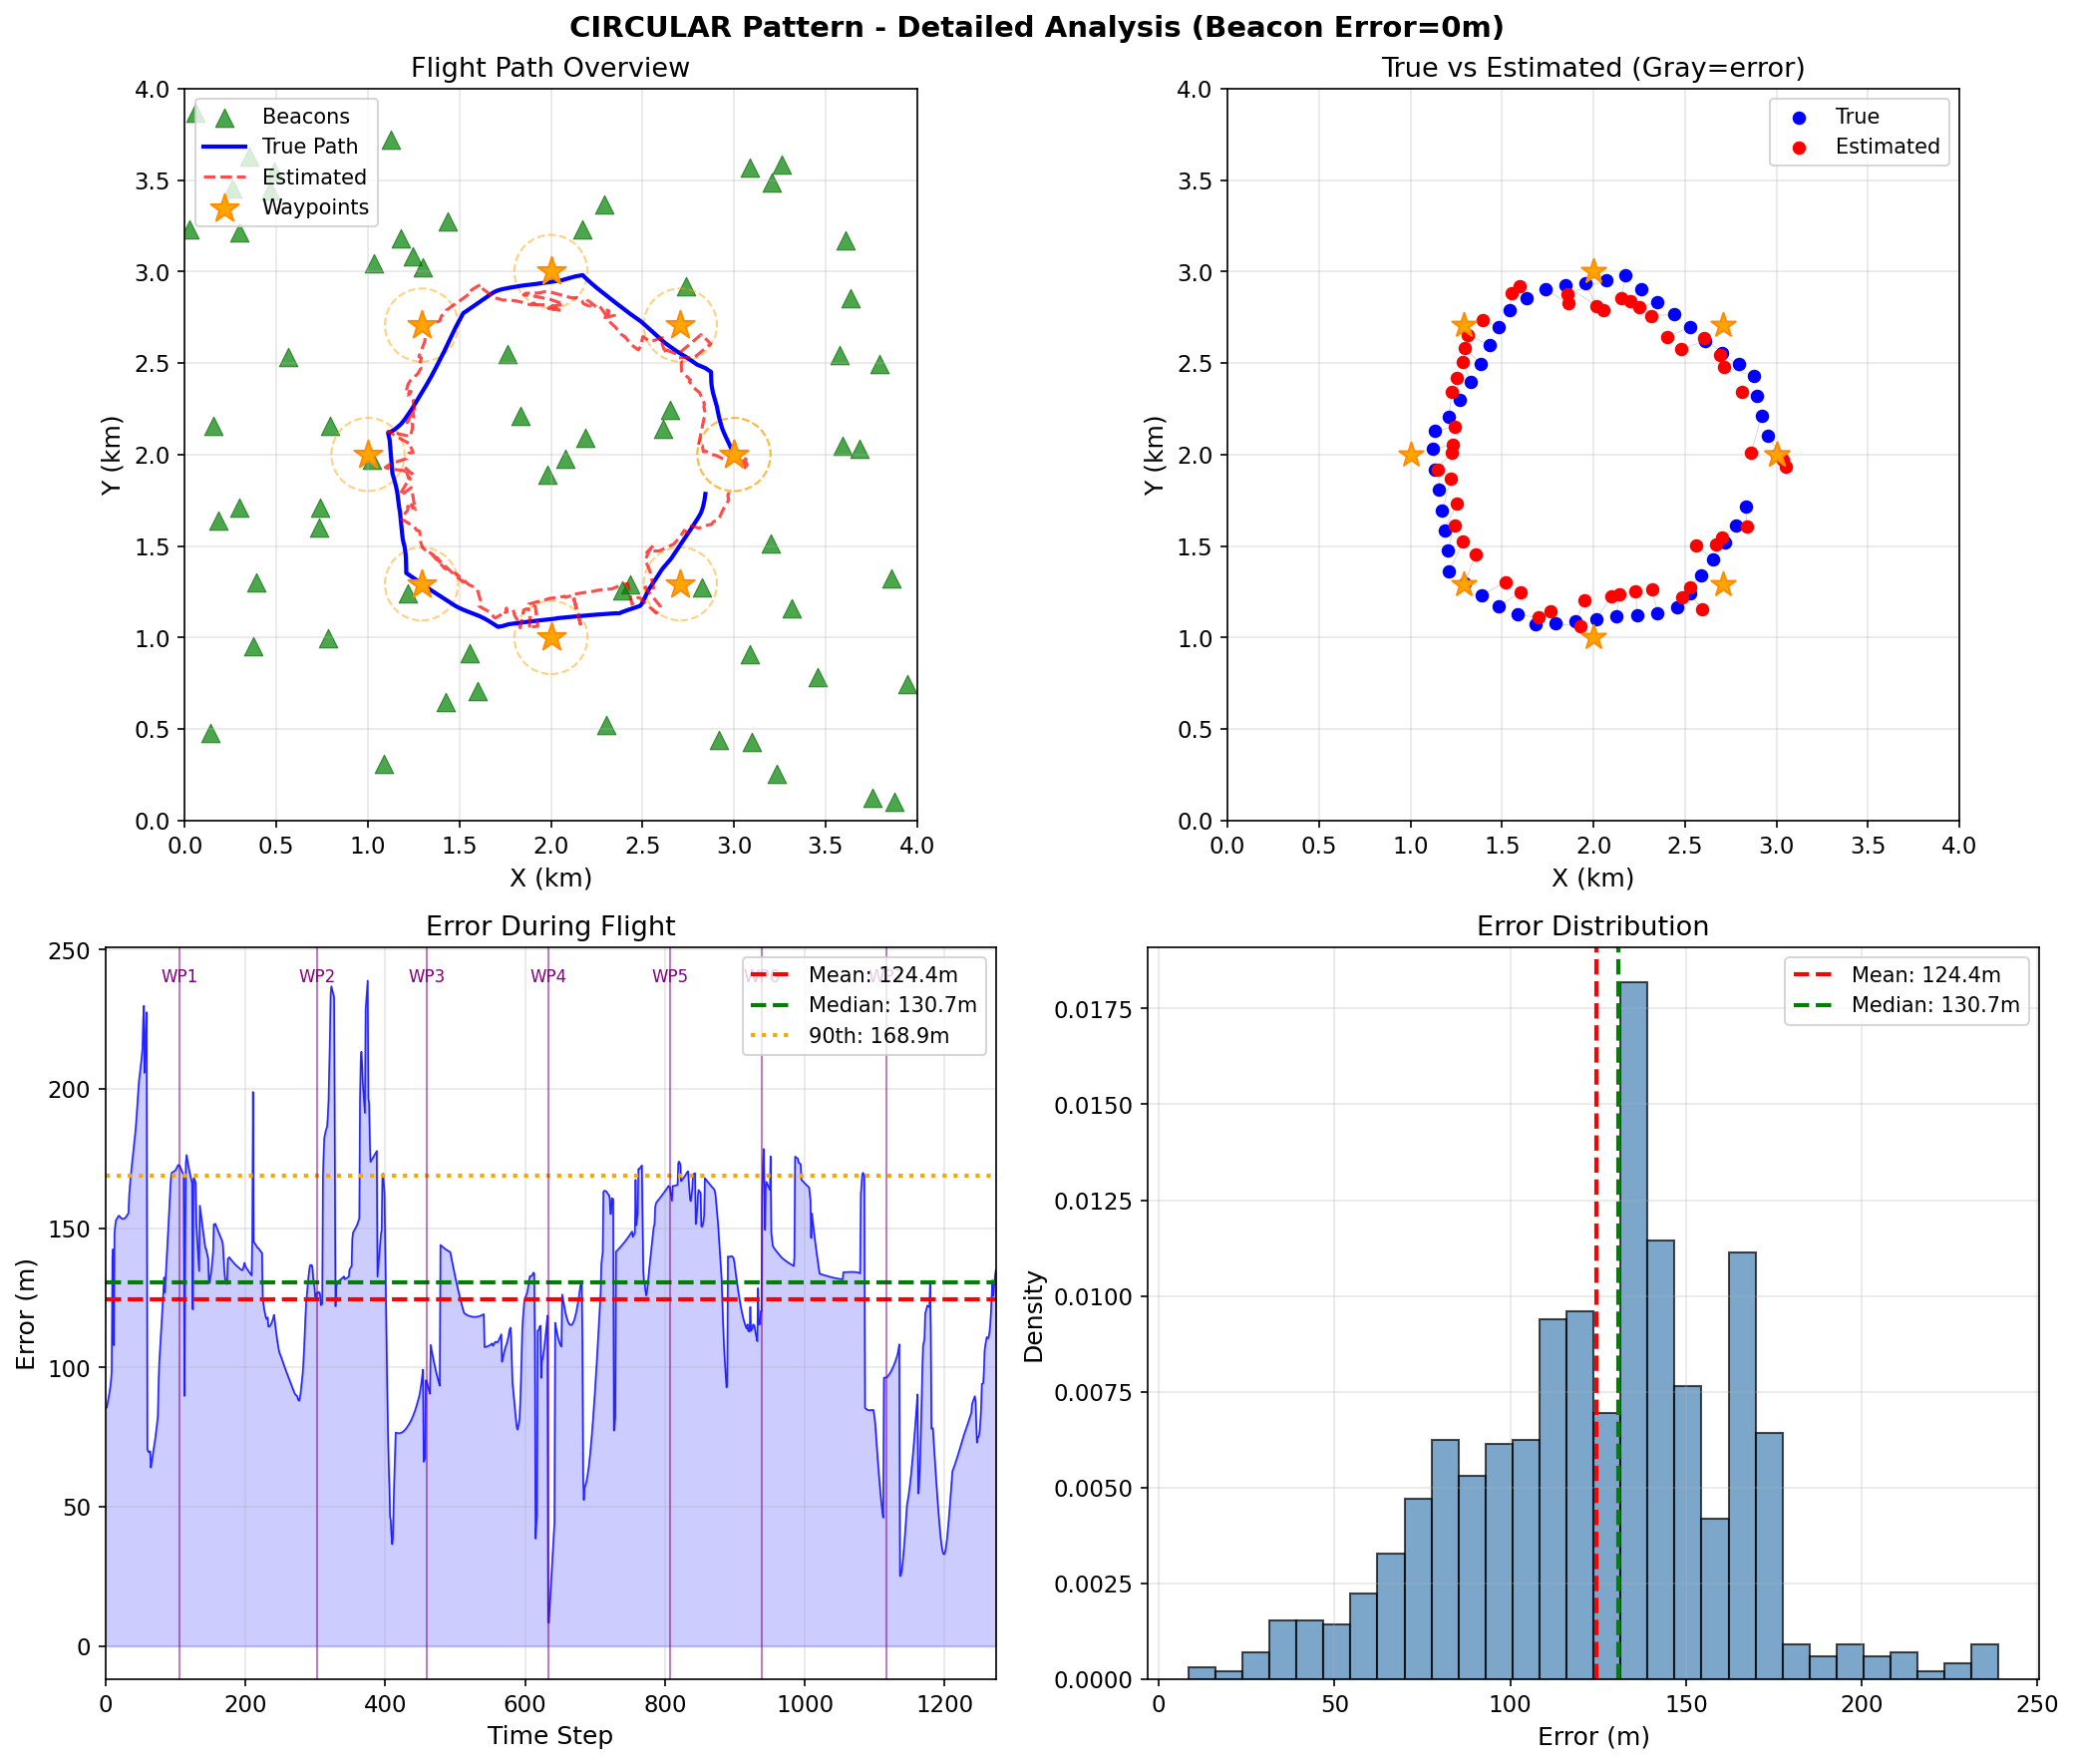

In [96]:
# Generate detailed analysis for CIRCULAR pattern at 0m and 200m beacon error
circular_waypoints = FLIGHT_PATTERNS['circular']

# Baseline (0m beacon error)
print("Generating: Circular pattern, 0m beacon error")
stats_0m = generate_detailed_flight_analysis(
    'circular', circular_waypoints, 0,
    f'{OUTPUT_DIR}/detailed_analysis_circular_0m.png'
)


Generating: Circular pattern, 200m beacon error (GCN level)
Saved: ../thesis/images/detailed_analysis_circular_200m.png


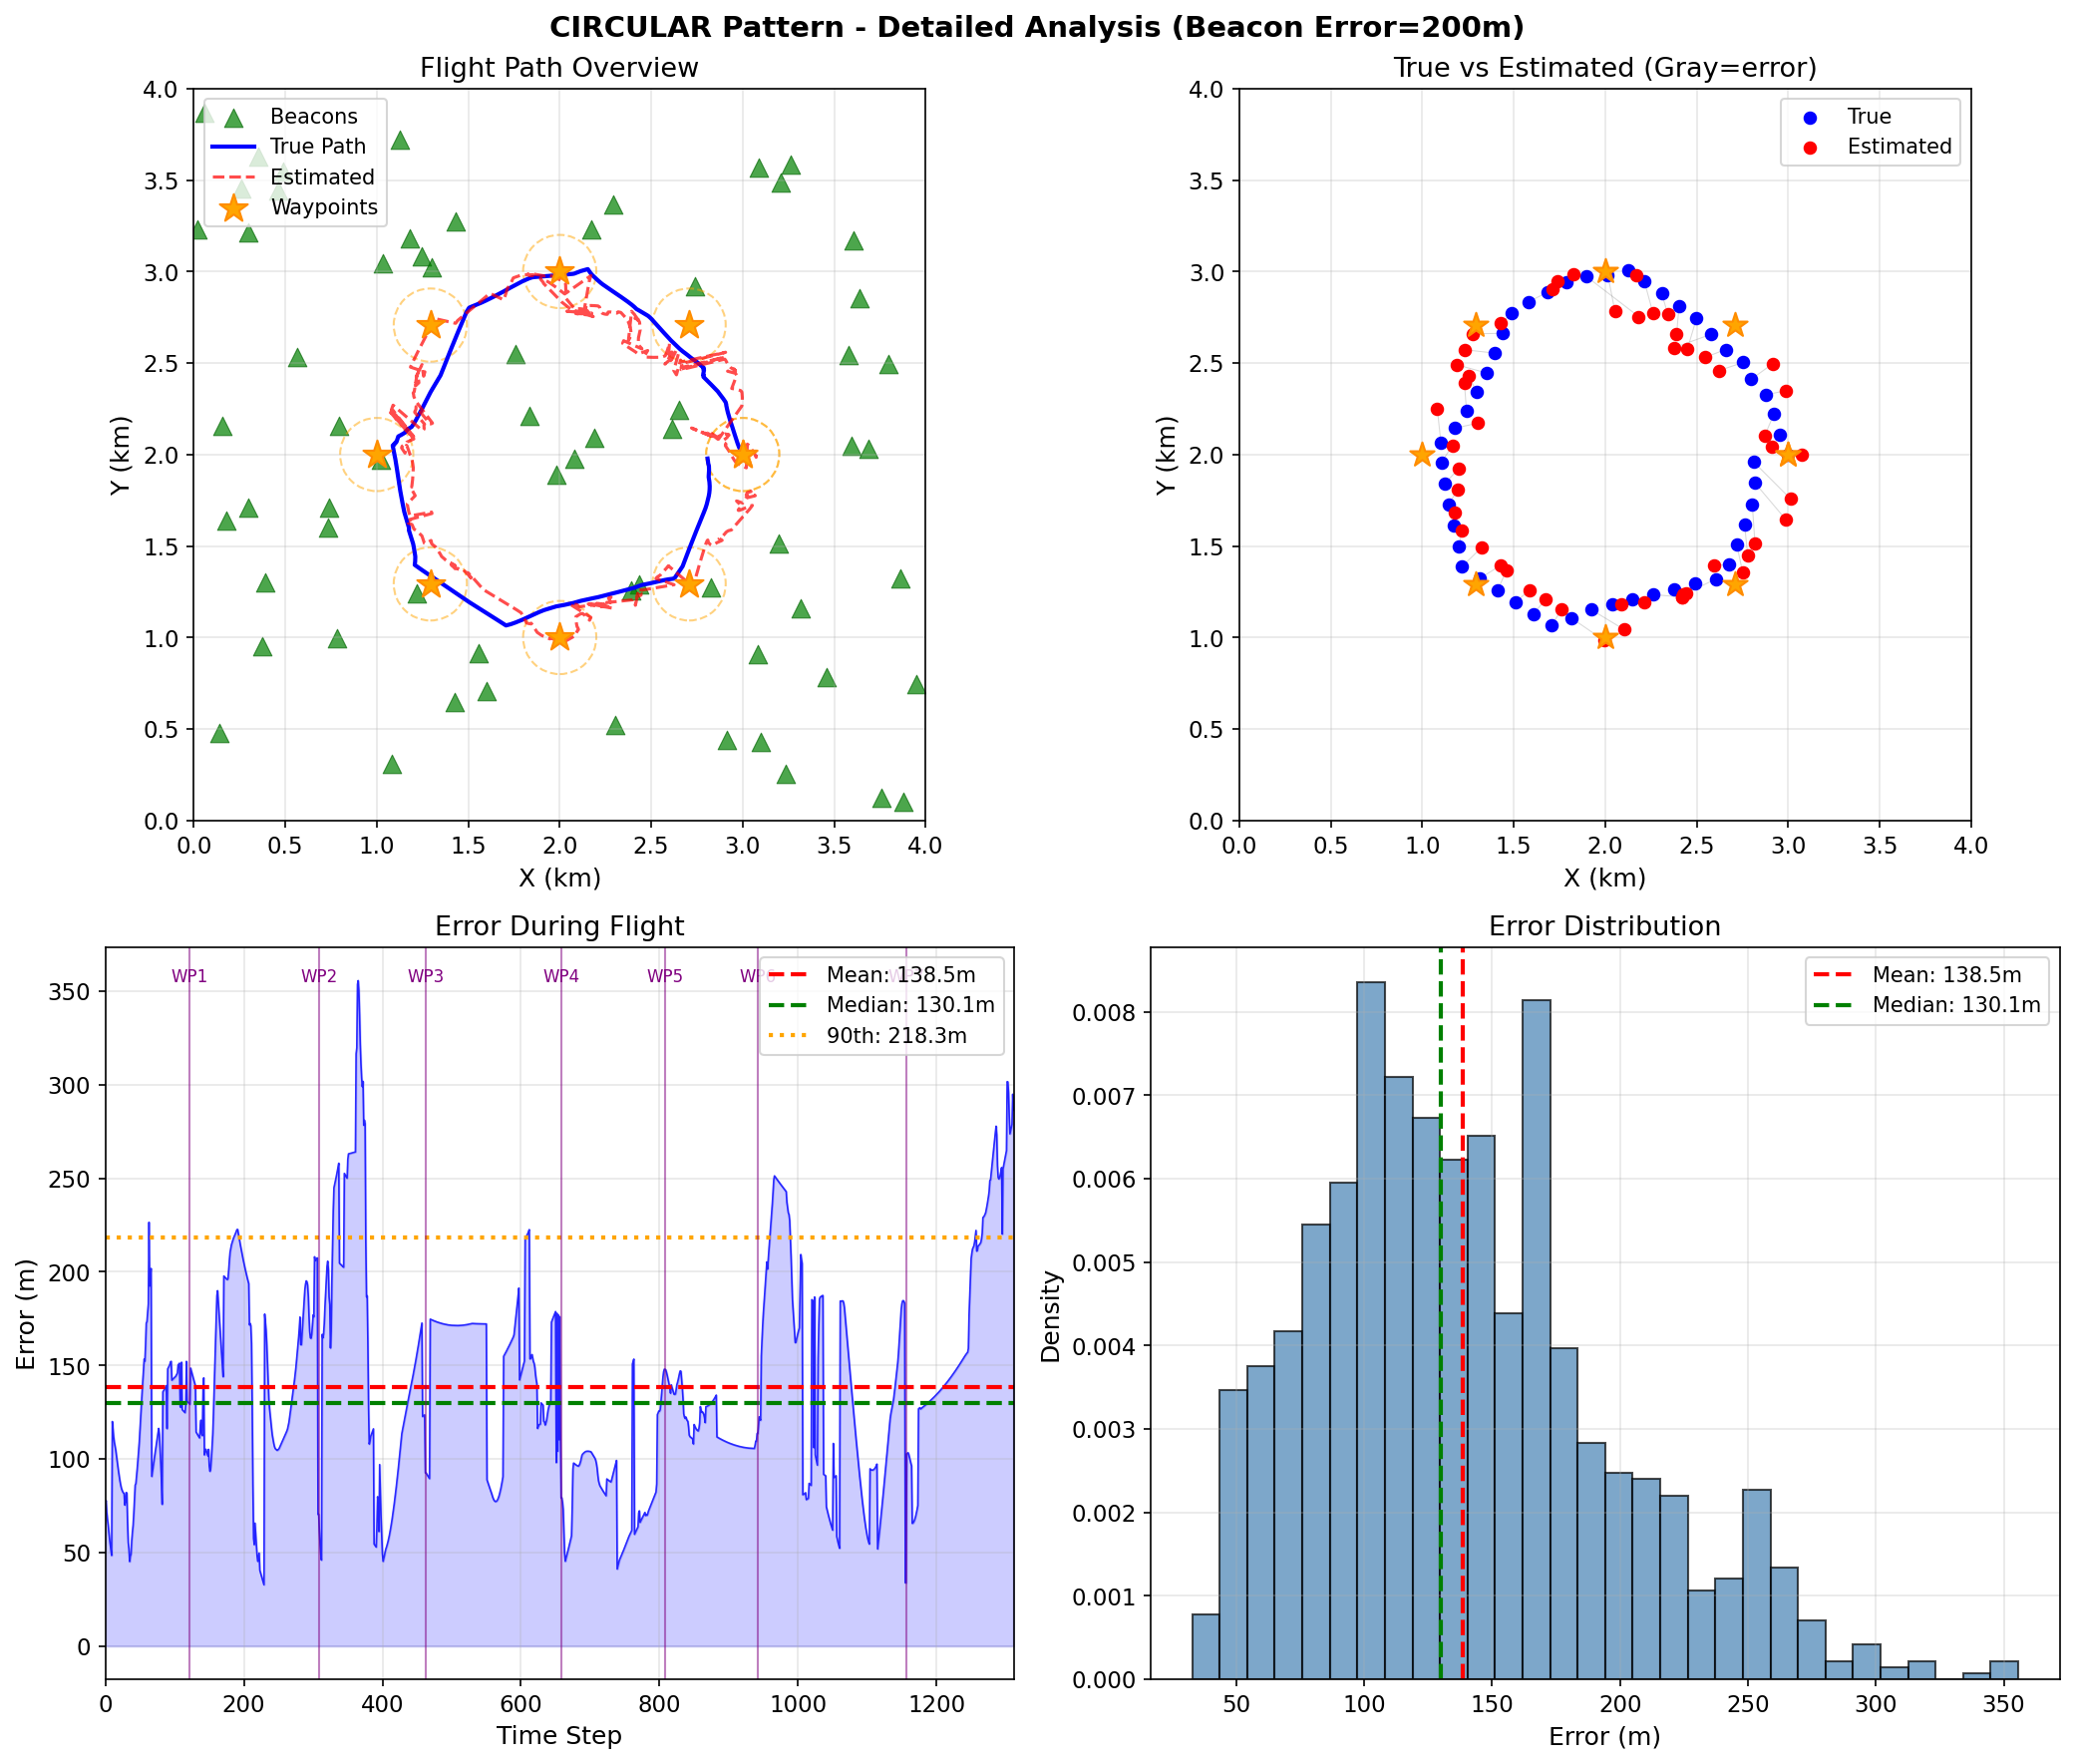


Comparison:
  0m beacon error:   Mean=124.4m, Median=130.7m
  200m beacon error: Mean=138.5m, Median=130.1m
  Degradation: 11.3%


In [102]:
# At GCN-level beacon error (~200m)
print("Generating: Circular pattern, 200m beacon error (GCN level)")
stats_200m = generate_detailed_flight_analysis(
    'circular', circular_waypoints, 200,
    f'{OUTPUT_DIR}/detailed_analysis_circular_200m.png'
)

print(f"\nComparison:")
print(f"  0m beacon error:   Mean={stats_0m['mean']:.1f}m, Median={stats_0m['median']:.1f}m")
print(f"  200m beacon error: Mean={stats_200m['mean']:.1f}m, Median={stats_200m['median']:.1f}m")
print(f"  Degradation: {(stats_200m['mean'] - stats_0m['mean']) / stats_0m['mean'] * 100:.1f}%")


### Figure 7: Grid-Wide Localization Visualization


In [103]:
def generate_grid_localization_figure(beacon_error, num_points=100, save_path=None):
    """
    Generate grid-wide localization visualization showing true vs estimated positions.
    """
    # Sample grid points uniformly
    np.random.seed(42)
    grid_step = int(np.sqrt(num_positions / num_points))
    sampled_indices = []
    for i in range(0, drone_grid_size, grid_step):
        for j in range(0, drone_grid_size, grid_step):
            idx = i * drone_grid_size + j
            if idx < num_positions:
                sampled_indices.append(idx)
    
    # Add noise to beacons
    noisy_bx, noisy_by = add_beacon_noise(beacon_x, beacon_y, beacon_error)
    
    # Localize each point
    true_positions = []
    est_positions = []
    errors = []
    
    for idx in sampled_indices:
        true_x, true_y = drone_x[idx], drone_y[idx]
        rssi_values = rssi_matrix[idx]
        
        est_x, est_y = multilaterate_top_k(
            rssi_values, noisy_bx, noisy_by, beacon_height,
            A_fit, n_fit, drone_altitude, k=10
        )
        
        true_positions.append((true_x, true_y))
        est_positions.append((est_x, est_y))
        errors.append(np.sqrt((est_x - true_x)**2 + (est_y - true_y)**2))
    
    true_positions = np.array(true_positions)
    est_positions = np.array(est_positions)
    
    mean_err = np.mean(errors)
    median_err = np.median(errors)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw error lines
    for i in range(len(true_positions)):
        ax.plot([true_positions[i, 0]/1000, est_positions[i, 0]/1000],
                [true_positions[i, 1]/1000, est_positions[i, 1]/1000],
                'gray', alpha=0.3, linewidth=0.5)
    
    # Plot points
    ax.scatter(true_positions[:, 0]/1000, true_positions[:, 1]/1000, 
               c='blue', s=40, label='True Positions', alpha=0.7, zorder=3)
    ax.scatter(est_positions[:, 0]/1000, est_positions[:, 1]/1000, 
               c='red', s=40, label='Estimated (Top-10)', alpha=0.7, zorder=3)
    
    # Plot beacons
    ax.scatter(beacon_x/1000, beacon_y/1000, c='green', marker='^', s=100, 
               label='Beacons', zorder=4, edgecolors='darkgreen', linewidth=1)
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_title(f'True vs Estimated Drone Positions (Beacon Error={beacon_error}m)\n'
                 f'Mean Error: {mean_err:.1f}m, Median: {median_err:.1f}m')
    ax.legend(loc='upper right')
    ax.set_xlim([0, map_size_meters/1000])
    ax.set_ylim([0, map_size_meters/1000])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
    plt.show()
    
    return {'mean': mean_err, 'median': median_err}

print("Grid localization visualization function defined.")


Grid localization visualization function defined.


Generating: Grid localization, 0m beacon error
Saved: ../thesis/images/grid_localization_0m.png


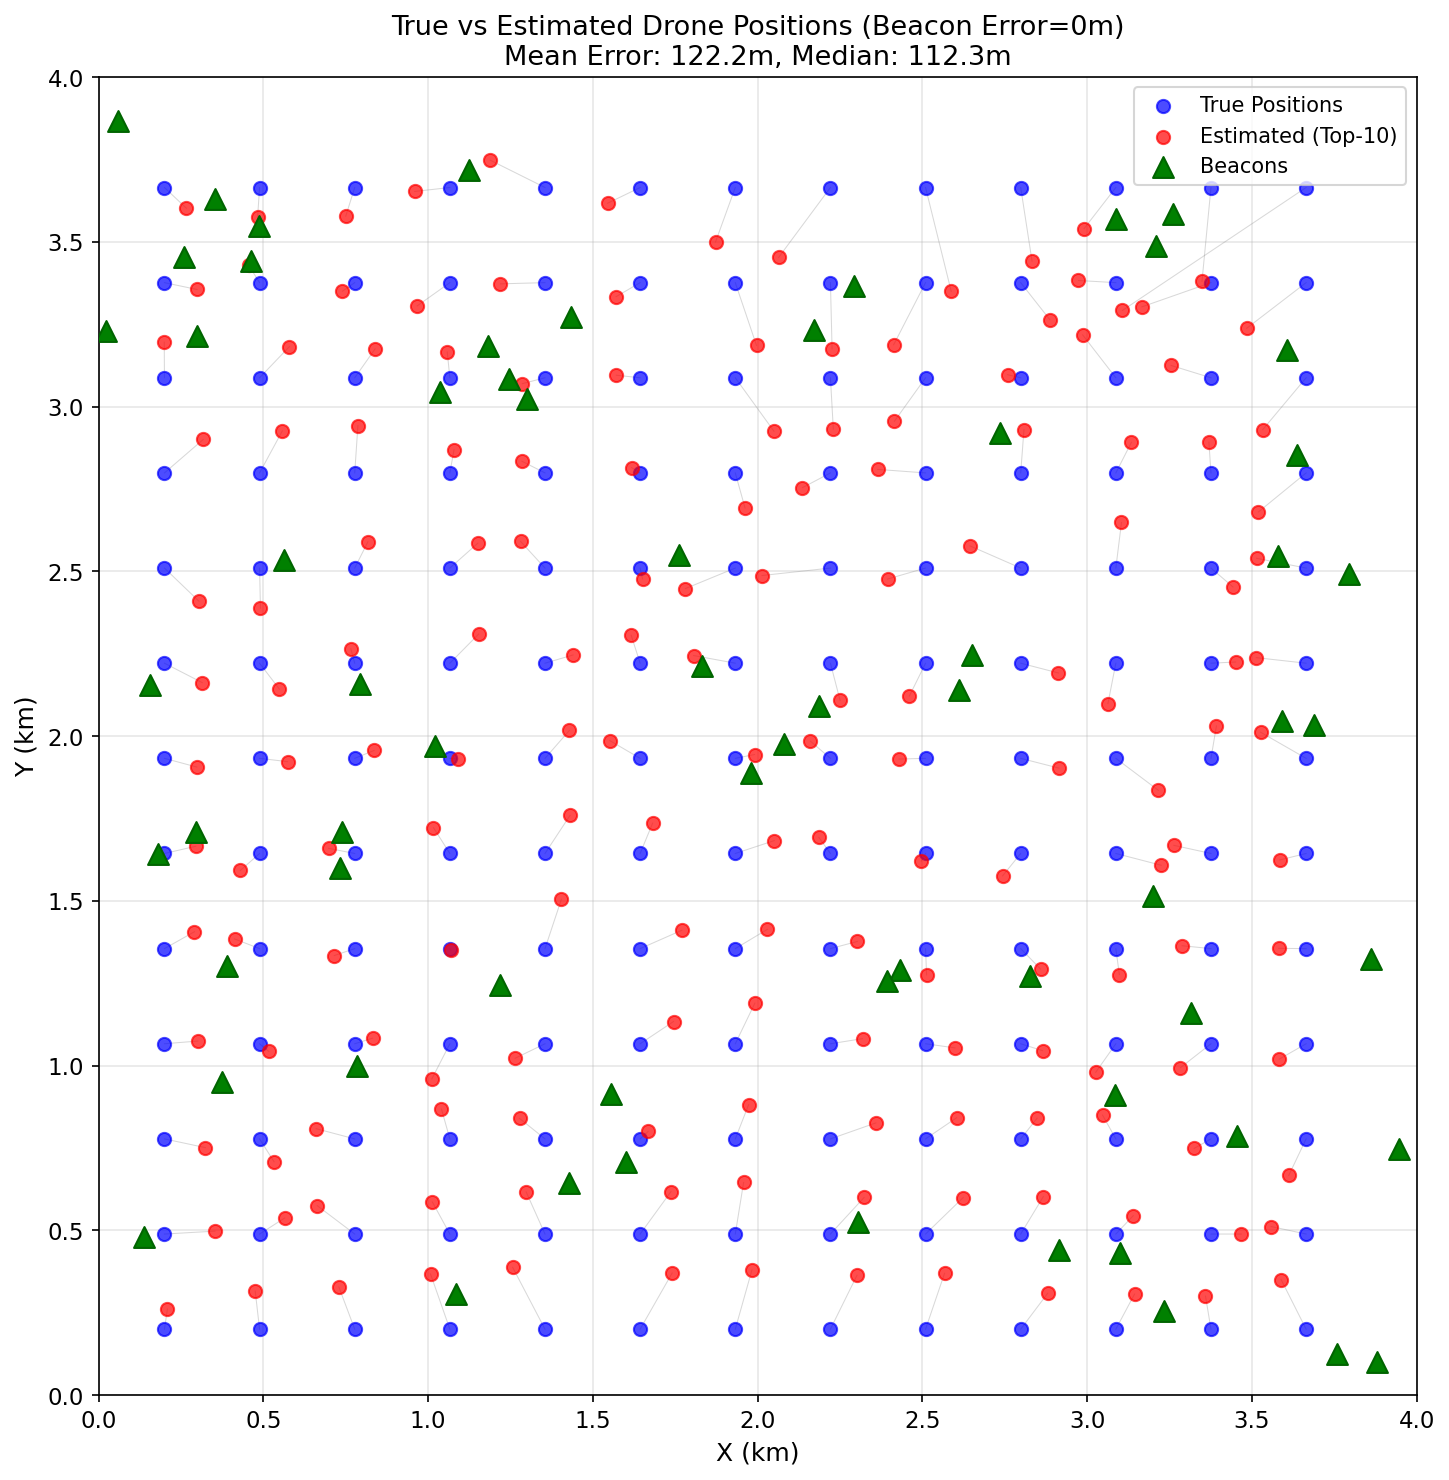

In [104]:
# Generate grid localization at 0m beacon error (baseline)
print("Generating: Grid localization, 0m beacon error")
grid_stats_0m = generate_grid_localization_figure(
    beacon_error=0,
    num_points=150,
    save_path=f'{OUTPUT_DIR}/grid_localization_0m.png'
)


Generating: Grid localization, 200m beacon error (GCN level)
Saved: ../thesis/images/grid_localization_200m.png


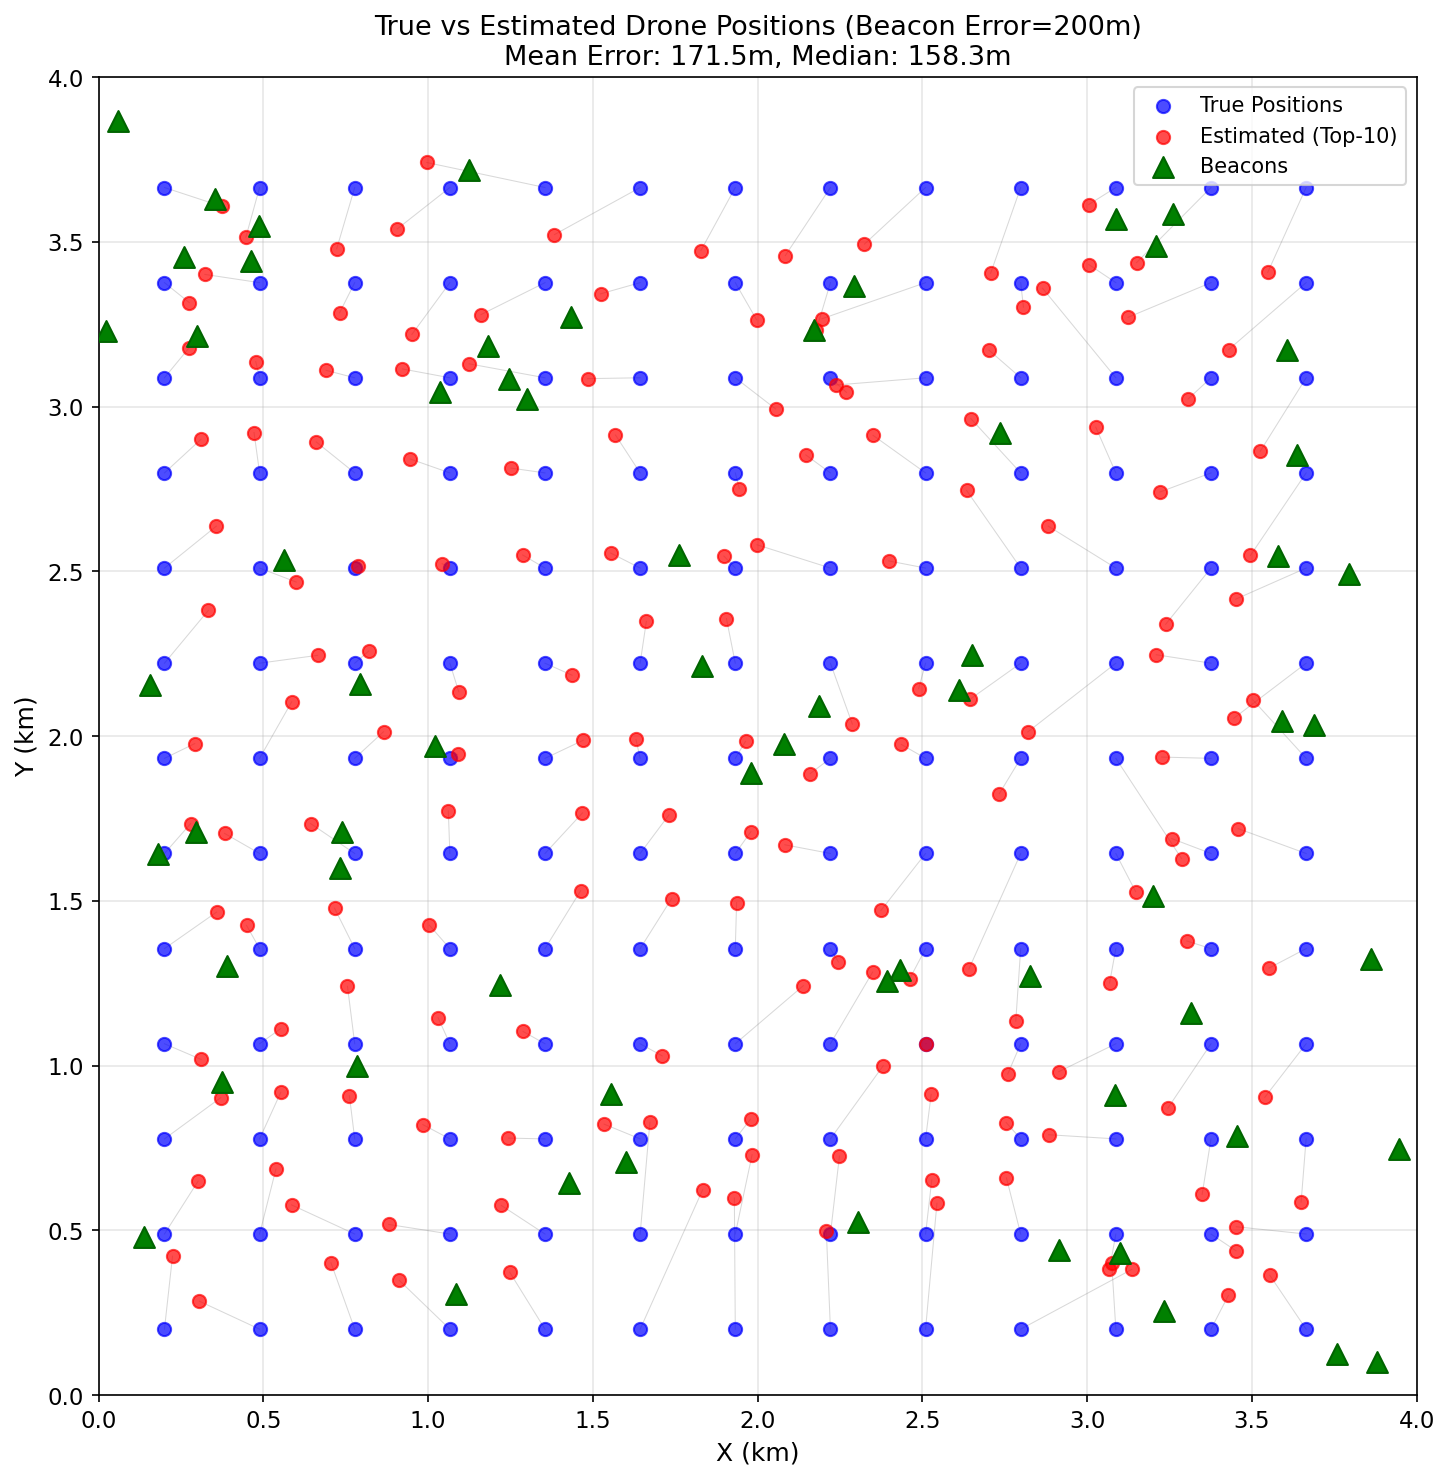


Grid Localization Comparison:
  0m beacon error:   Mean=122.2m, Median=112.3m
  200m beacon error: Mean=171.5m, Median=158.3m


In [105]:
# Generate grid localization at 200m beacon error (GCN level)
print("Generating: Grid localization, 200m beacon error (GCN level)")
grid_stats_200m = generate_grid_localization_figure(
    beacon_error=200,
    num_points=150,
    save_path=f'{OUTPUT_DIR}/grid_localization_200m.png'
)

print(f"\nGrid Localization Comparison:")
print(f"  0m beacon error:   Mean={grid_stats_0m['mean']:.1f}m, Median={grid_stats_0m['median']:.1f}m")
print(f"  200m beacon error: Mean={grid_stats_200m['mean']:.1f}m, Median={grid_stats_200m['median']:.1f}m")


### Figure 8: Lawnmower Pattern (Area Sweep)


Generating: Area sweep pattern, 0m beacon error
Saved: ../thesis/images/detailed_analysis_area_sweep_0m.png


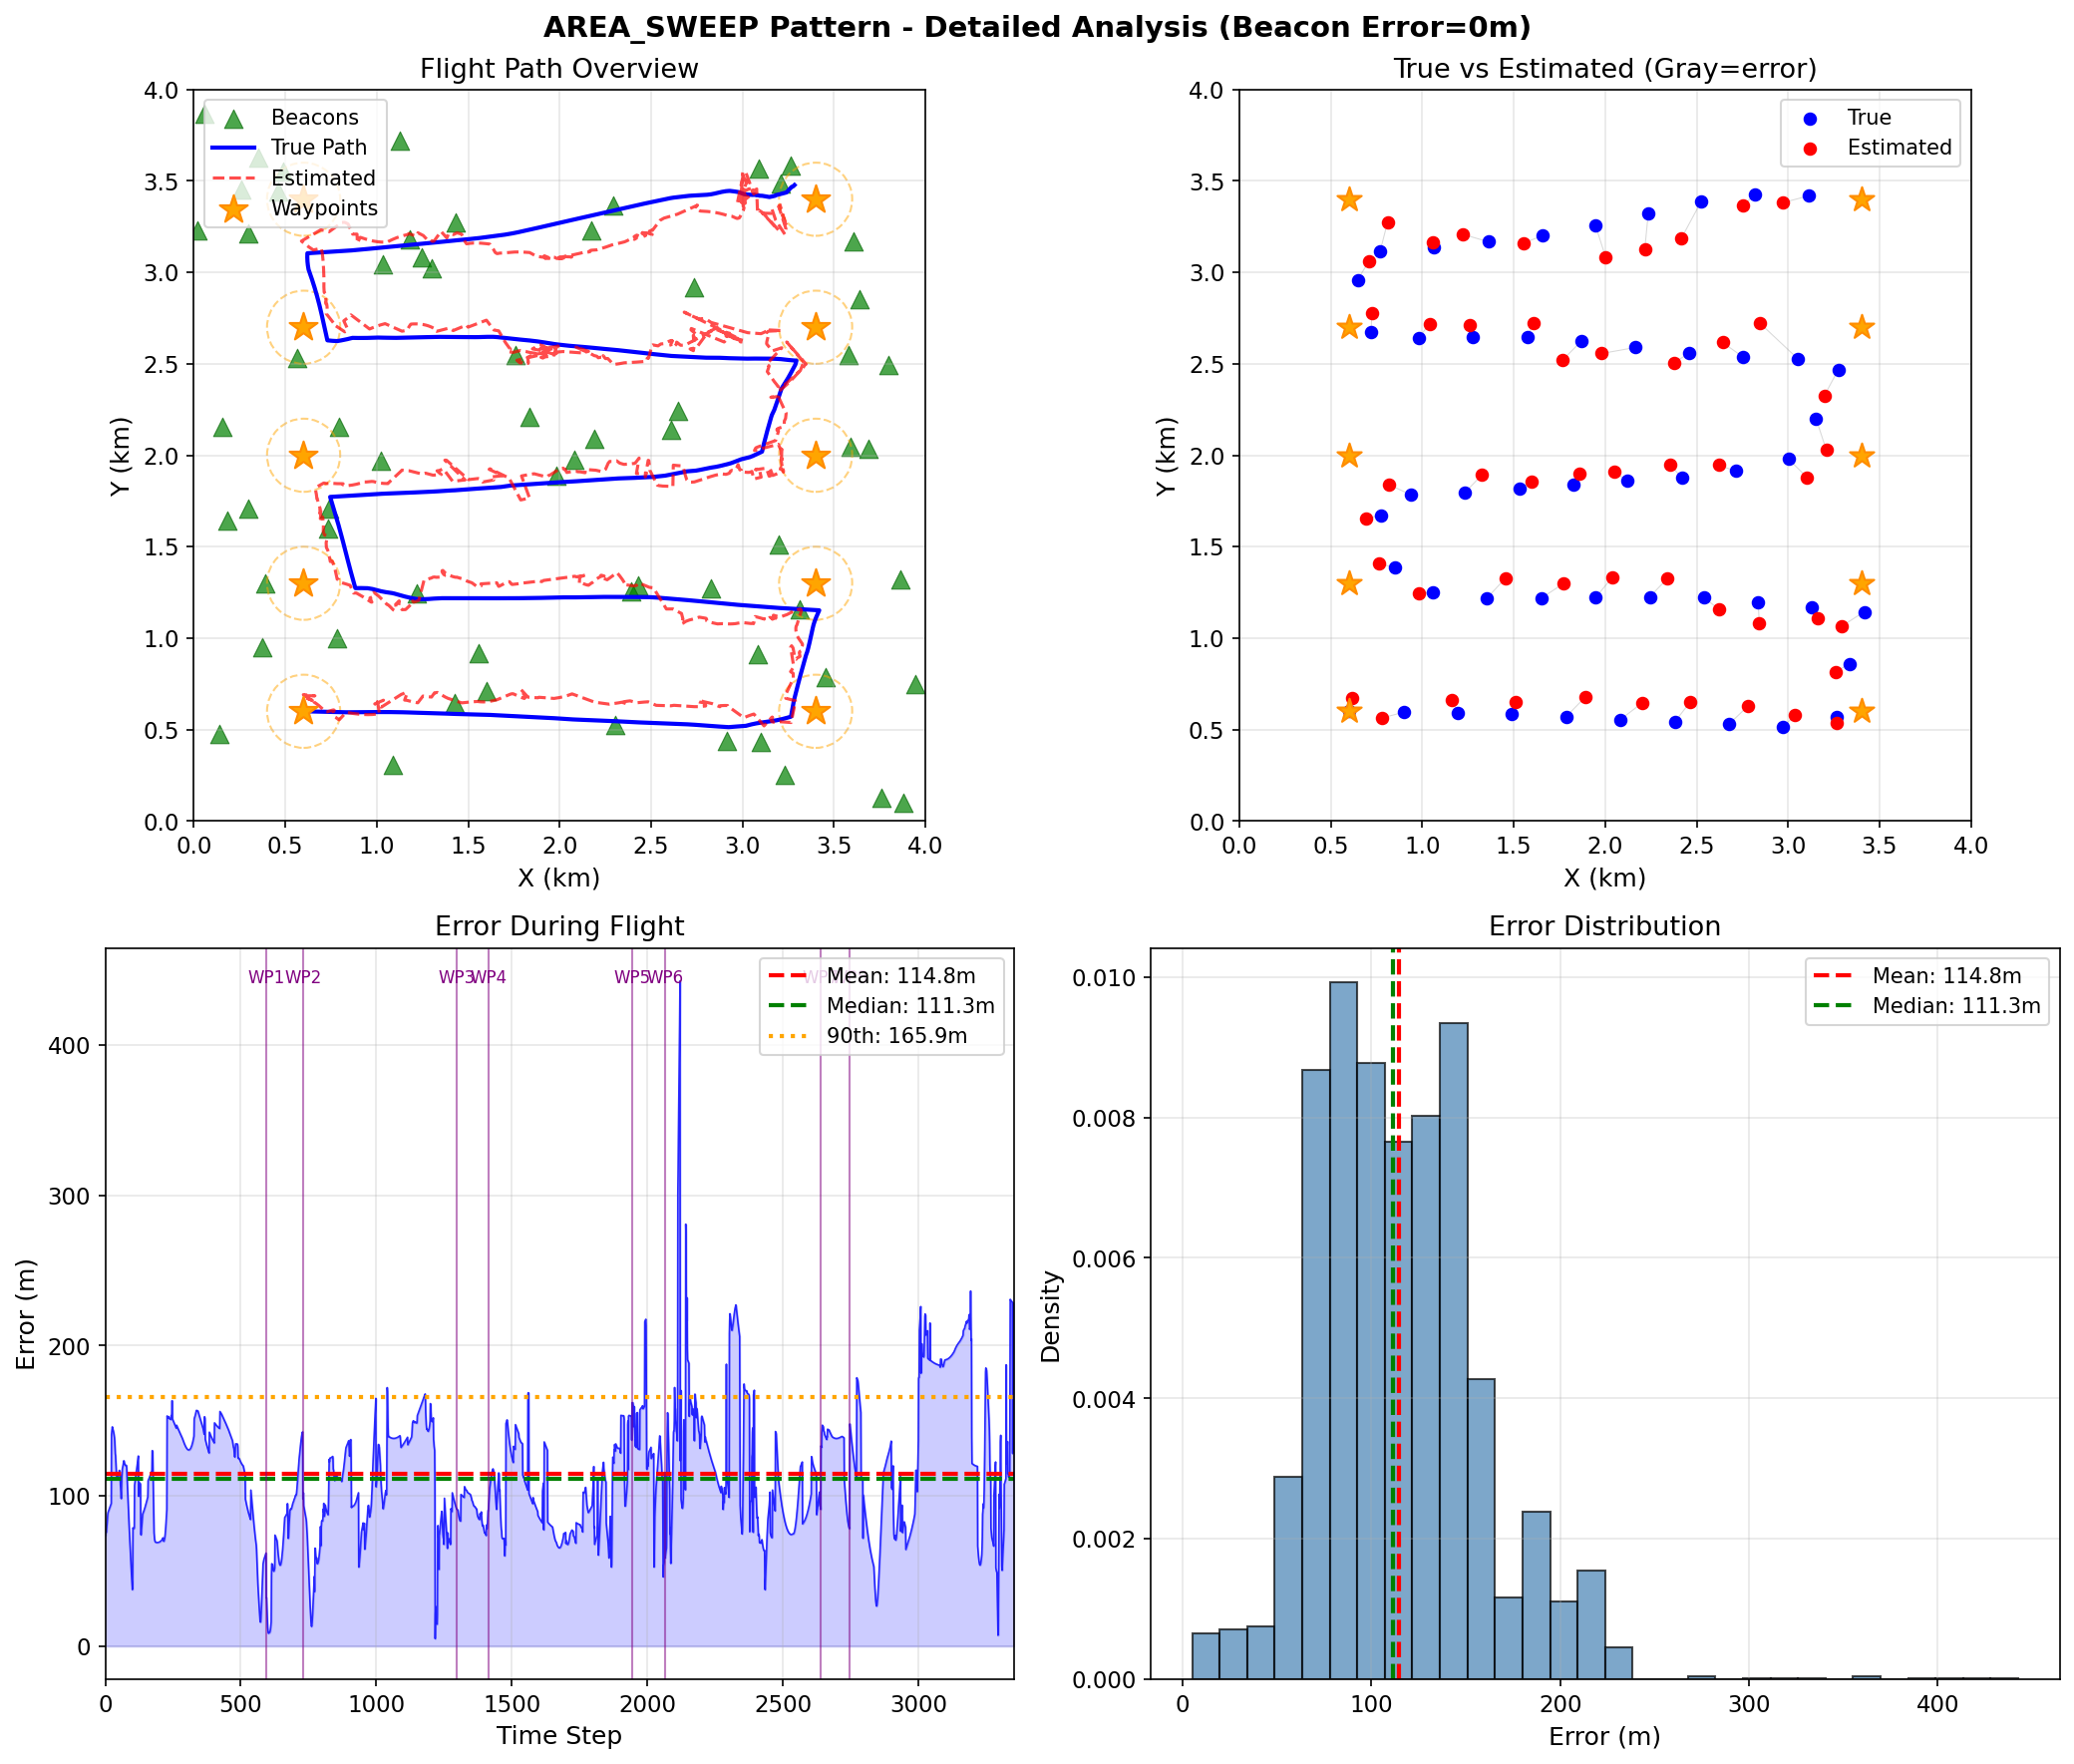


Generating: Area sweep pattern, 200m beacon error
Saved: ../thesis/images/detailed_analysis_area_sweep_200m.png


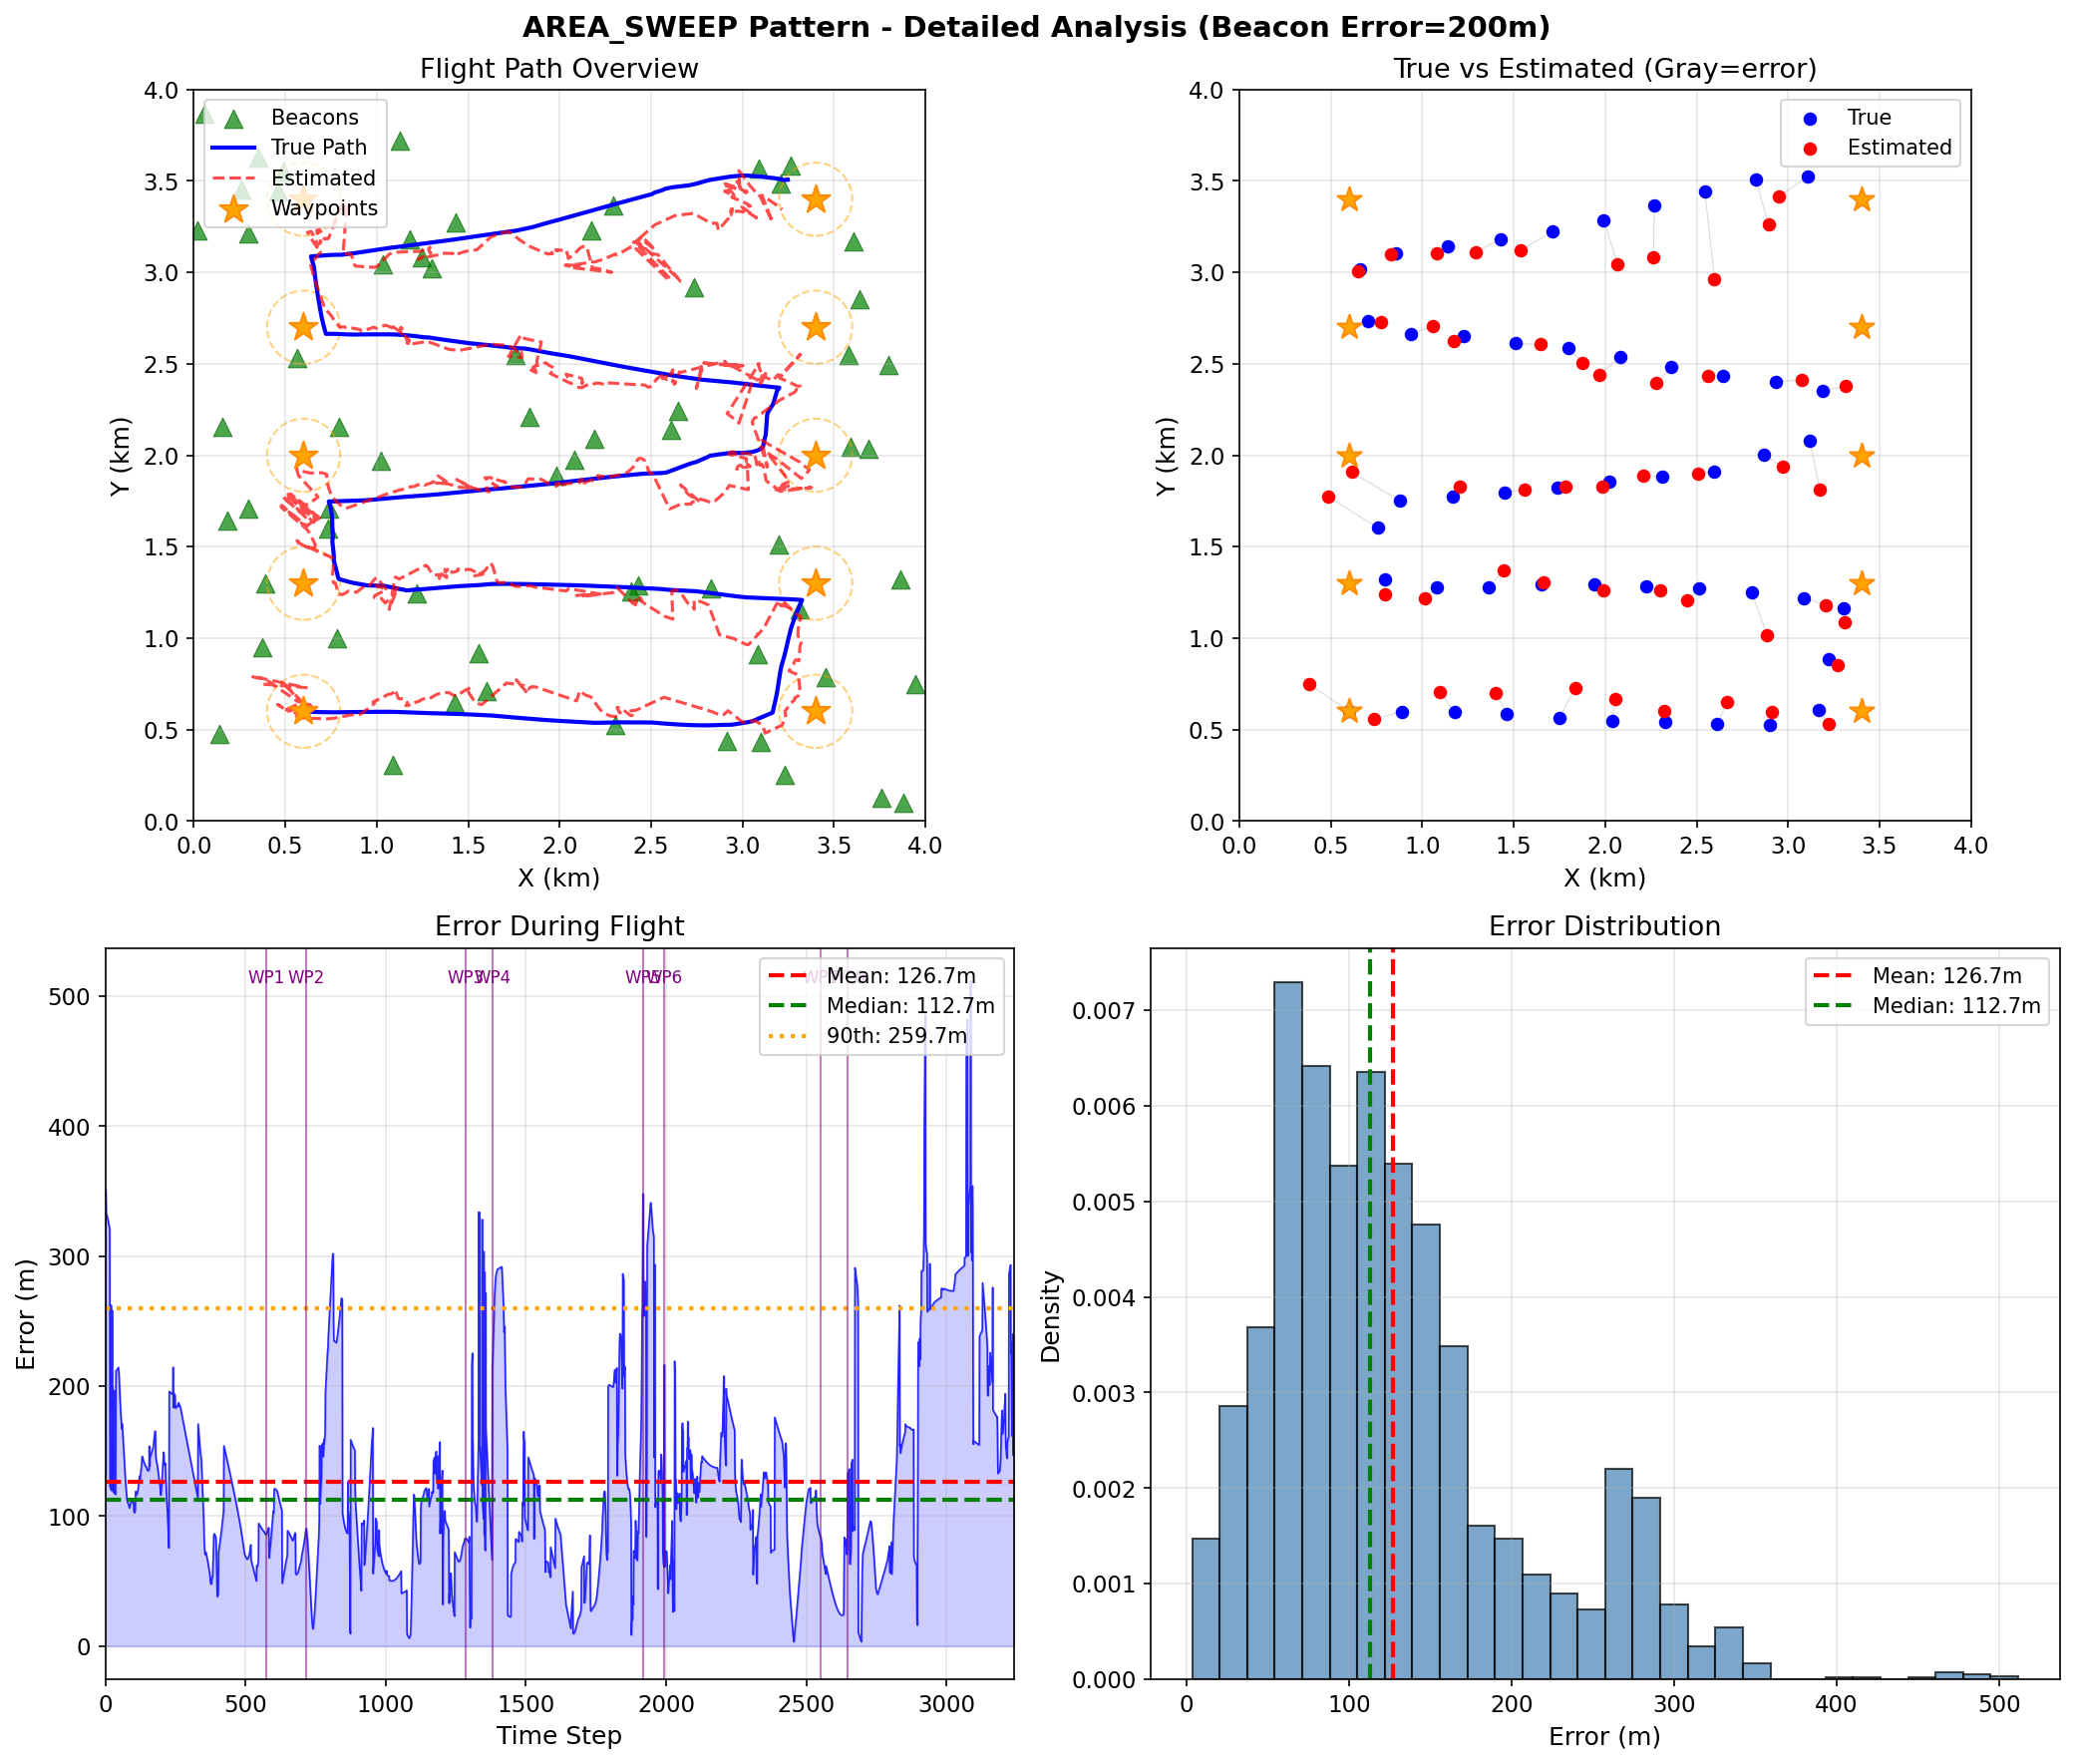

In [106]:
# Generate detailed analysis for AREA SWEEP pattern
area_sweep_waypoints = FLIGHT_PATTERNS['area_sweep']

print("Generating: Area sweep pattern, 0m beacon error")
area_sweep_stats_0m = generate_detailed_flight_analysis(
    'area_sweep', area_sweep_waypoints, 0,
    f'{OUTPUT_DIR}/detailed_analysis_area_sweep_0m.png'
)

print("\nGenerating: Area sweep pattern, 200m beacon error")
area_sweep_stats_200m = generate_detailed_flight_analysis(
    'area_sweep', area_sweep_waypoints, 200,
    f'{OUTPUT_DIR}/detailed_analysis_area_sweep_200m.png'
)


In [107]:
# ============================================================================
# Generate INDIVIDUAL figures for thesis (separate PNGs)
# ============================================================================

def run_flight_and_get_data(pattern_name, waypoints, beacon_error):
    """Run simulation and return data for plotting."""
    noisy_bx, noisy_by = add_beacon_noise(beacon_x, beacon_y, beacon_error)
    
    sim = DroneSimulator(
        start_pos=waypoints[0],
        waypoint_threshold=200,
        max_sim_steps=2000
    )
    wp_results = sim.fly_mission(waypoints[1:], noisy_bx, noisy_by, verbose=False,
                                  original_beacon_error=beacon_error)
    
    return {
        'true_path': np.array(sim.true_path),
        'est_path': np.array(sim.estimated_path),
        'errors': np.array(sim.localization_errors),
        'wp_results': wp_results,
        'waypoints': np.array(waypoints)
    }

def save_path_figure(data, pattern_name, beacon_error, save_path):
    """Save flight path overview figure."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    true_path = data['true_path']
    est_path = data['est_path']
    wp_array = data['waypoints']
    
    # Plot beacons
    ax.scatter(beacon_x/1000, beacon_y/1000, c='green', marker='^', s=80, 
               label='Beacons', alpha=0.7, edgecolors='darkgreen', linewidth=0.5)
    
    # Plot true path
    ax.plot(true_path[:, 0]/1000, true_path[:, 1]/1000, 'b-', linewidth=2, label='True Path')
    
    # Plot estimated path
    ax.plot(est_path[:, 0]/1000, est_path[:, 1]/1000, 'r--', linewidth=1.5, 
            alpha=0.7, label='Estimated')
    
    # Plot waypoints
    ax.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', marker='*', 
               s=200, label='Waypoints', zorder=5, edgecolors='darkorange', linewidth=1)
    
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_ylabel('Y (km)', fontsize=12)
    ax.set_title(f'Flight Path Overview ({pattern_name}, Beacon Error={beacon_error}m)', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.set_xlim([0, map_size_meters/1000])
    ax.set_ylim([0, map_size_meters/1000])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Saved: {save_path}")

def save_true_vs_est_figure(data, pattern_name, beacon_error, save_path):
    """Save true vs estimated positions figure."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    true_path = data['true_path']
    est_path = data['est_path']
    wp_array = data['waypoints']
    
    # Sample for clarity
    sample_step = max(1, len(true_path) // 50)
    sampled_true = true_path[::sample_step]
    sampled_est = est_path[::sample_step] if len(est_path) >= len(true_path[::sample_step]) else est_path
    min_len = min(len(sampled_true), len(sampled_est))
    sampled_true = sampled_true[:min_len]
    sampled_est = sampled_est[:min_len]
    
    # Draw error lines
    for i in range(min_len):
        ax.plot([sampled_true[i, 0]/1000, sampled_est[i, 0]/1000],
                [sampled_true[i, 1]/1000, sampled_est[i, 1]/1000],
                'gray', alpha=0.4, linewidth=0.8)
    
    ax.scatter(sampled_true[:, 0]/1000, sampled_true[:, 1]/1000, c='blue', s=40, 
               label='True', zorder=3)
    ax.scatter(sampled_est[:, 0]/1000, sampled_est[:, 1]/1000, c='red', s=40, 
               label='Estimated', zorder=3)
    ax.scatter(wp_array[:, 0]/1000, wp_array[:, 1]/1000, c='orange', marker='*', 
               s=150, zorder=5, edgecolors='darkorange')
    
    ax.set_xlabel('X (km)', fontsize=12)
    ax.set_ylabel('Y (km)', fontsize=12)
    ax.set_title(f'True vs Estimated ({pattern_name}, Beacon Error={beacon_error}m)', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlim([0, map_size_meters/1000])
    ax.set_ylim([0, map_size_meters/1000])
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Saved: {save_path}")

def save_error_timeline_figure(data, pattern_name, beacon_error, save_path):
    """Save error timeline figure."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    errors = data['errors']
    wp_results = data['wp_results']
    
    time_steps = np.arange(len(errors))
    ax.plot(time_steps, errors, 'b-', linewidth=0.8, alpha=0.8)
    ax.fill_between(time_steps, 0, errors, alpha=0.2, color='blue')
    
    mean_err = np.mean(errors)
    median_err = np.median(errors)
    p90_err = np.percentile(errors, 90)
    
    ax.axhline(mean_err, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_err:.1f}m')
    ax.axhline(median_err, color='green', linestyle='--', linewidth=2, 
               label=f'Median: {median_err:.1f}m')
    ax.axhline(p90_err, color='orange', linestyle=':', linewidth=2, 
               label=f'90th: {p90_err:.1f}m')
    
    # Add waypoint markers
    cumulative_steps = 0
    for i, result in enumerate(wp_results):
        cumulative_steps += result['steps']
        if cumulative_steps < len(errors):
            ax.axvline(cumulative_steps, color='purple', linestyle='-', 
                      alpha=0.5, linewidth=1)
            ax.text(cumulative_steps, ax.get_ylim()[1] * 0.95, f'WP{i+1}', 
                   fontsize=9, ha='center', color='purple')
    
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Localization Error (m)', fontsize=12)
    ax.set_title(f'Error During Flight ({pattern_name}, Beacon Error={beacon_error}m)', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, len(errors)])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Saved: {save_path}")

def save_error_dist_figure(data, pattern_name, beacon_error, save_path):
    """Save error distribution histogram figure."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    errors = data['errors']
    mean_err = np.mean(errors)
    median_err = np.median(errors)
    
    ax.hist(errors, bins=30, density=True, color='steelblue', 
            edgecolor='black', alpha=0.7)
    
    ax.axvline(mean_err, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_err:.1f}m')
    ax.axvline(median_err, color='green', linestyle='--', linewidth=2, 
               label=f'Median: {median_err:.1f}m')
    
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Error Distribution ({pattern_name}, Beacon Error={beacon_error}m)', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Saved: {save_path}")

print("Individual figure functions defined.")


Individual figure functions defined.


In [108]:
# Generate all individual figures for thesis
# Patterns: diagonal, circular, area_sweep
# Beacon errors: 0m (baseline), 200m (GCN level)

PATTERNS_TO_GENERATE = ['diagonal', 'circular', 'area_sweep']
BEACON_ERRORS = [0, 200]

all_stats = {}

for pattern_name in PATTERNS_TO_GENERATE:
    waypoints = FLIGHT_PATTERNS[pattern_name]
    all_stats[pattern_name] = {}
    
    for beacon_error in BEACON_ERRORS:
        print(f"\n{'='*60}")
        print(f"Generating: {pattern_name} pattern, {beacon_error}m beacon error")
        print(f"{'='*60}")
        
        # Run simulation
        data = run_flight_and_get_data(pattern_name, waypoints, beacon_error)
        
        # Generate file prefix
        prefix = f"{OUTPUT_DIR}/{pattern_name}_beacon{beacon_error}m"
        
        # Save individual figures
        save_path_figure(data, pattern_name, beacon_error, f"{prefix}_path.png")
        save_true_vs_est_figure(data, pattern_name, beacon_error, f"{prefix}_true_vs_est.png")
        save_error_timeline_figure(data, pattern_name, beacon_error, f"{prefix}_error_timeline.png")
        save_error_dist_figure(data, pattern_name, beacon_error, f"{prefix}_error_dist.png")
        
        # Store statistics
        errors = data['errors']
        all_stats[pattern_name][beacon_error] = {
            'mean': np.mean(errors),
            'median': np.median(errors),
            'p90': np.percentile(errors, 90),
            'max': np.max(errors)
        }
        
        print(f"  Stats: Mean={all_stats[pattern_name][beacon_error]['mean']:.1f}m, "
              f"Median={all_stats[pattern_name][beacon_error]['median']:.1f}m, "
              f"90th={all_stats[pattern_name][beacon_error]['p90']:.1f}m")

print("\n" + "="*60)
print("All individual figures generated!")
print("="*60)



Generating: diagonal pattern, 0m beacon error
  Saved: ../thesis/images/diagonal_beacon0m_path.png
  Saved: ../thesis/images/diagonal_beacon0m_true_vs_est.png
  Saved: ../thesis/images/diagonal_beacon0m_error_timeline.png
  Saved: ../thesis/images/diagonal_beacon0m_error_dist.png
  Stats: Mean=111.9m, Median=113.1m, 90th=161.9m

Generating: diagonal pattern, 200m beacon error
  Saved: ../thesis/images/diagonal_beacon200m_path.png
  Saved: ../thesis/images/diagonal_beacon200m_true_vs_est.png
  Saved: ../thesis/images/diagonal_beacon200m_error_timeline.png
  Saved: ../thesis/images/diagonal_beacon200m_error_dist.png
  Stats: Mean=155.4m, Median=132.0m, 90th=240.8m

Generating: circular pattern, 0m beacon error
  Saved: ../thesis/images/circular_beacon0m_path.png
  Saved: ../thesis/images/circular_beacon0m_true_vs_est.png
  Saved: ../thesis/images/circular_beacon0m_error_timeline.png
  Saved: ../thesis/images/circular_beacon0m_error_dist.png
  Stats: Mean=124.4m, Median=130.7m, 90th=168.

Saved: ../thesis/images/sensitivity_uav_vs_beacon.png


Saved: ../thesis/images/sensitivity_p90.png


Saved: ../thesis/images/geometric_stability.png


KEY NUMERICAL RESULTS FOR CHAPTER 6

SENSITIVITY ANALYSIS (Grid-Wide Localization):
  Baseline (0m beacon error):
    - Mean:   122.3m
    - Median: 115.2m
    - P90:    181.6m

  At 150m beacon error:
    - Mean:   124.6m
    - Median: 112.1m
    - P90:    219.9m

  At 200m beacon error (GCN level):
    - Mean:   157.2m
    - Median: 134.1m
    - P90:    287.3m

  Error Degradation (baseline -> 200m):
    - Mean increase: 34.8m (28.5%)

NAVIGATION SIMULATION RESULTS:

  DIAGONAL:
    Beacon Error=0m: Success=100%, Loc Error=111.9m, Heading Error=4.7°
    Beacon Error=100m: Success=100%, Loc Error=112.7m, Heading Error=5.4°
    Beacon Error=150m: Success=100%, Loc Error=144.4m, Heading Error=5.0°
    Beacon Error=200m: Success=100%, Loc Error=151.8m, Heading Error=7.6°
    Beacon Error=250m: Success=67%, Loc Error=255.1m, Heading Error=22.0°

  CIRCULAR:
    Beacon Error=0m: Success=100%, Loc Error=124.4m, Heading Error=10.2°
    Beacon Error=100m: Success=100%, Loc Error=111.6m, Headi